# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper:
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [4]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image.

We write a little datast that does nothing except calculating per-pixel coordinates:

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [6]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

C:\Users\stevenT\PycharmProjects\SIREN\.venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.318907


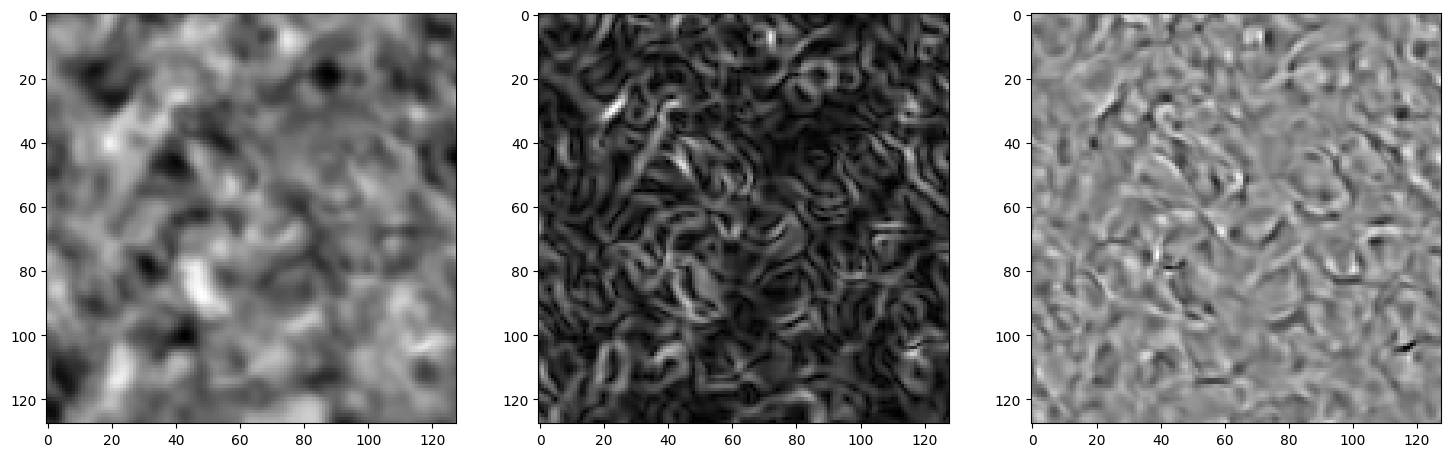

Step 10, Total loss 0.193297


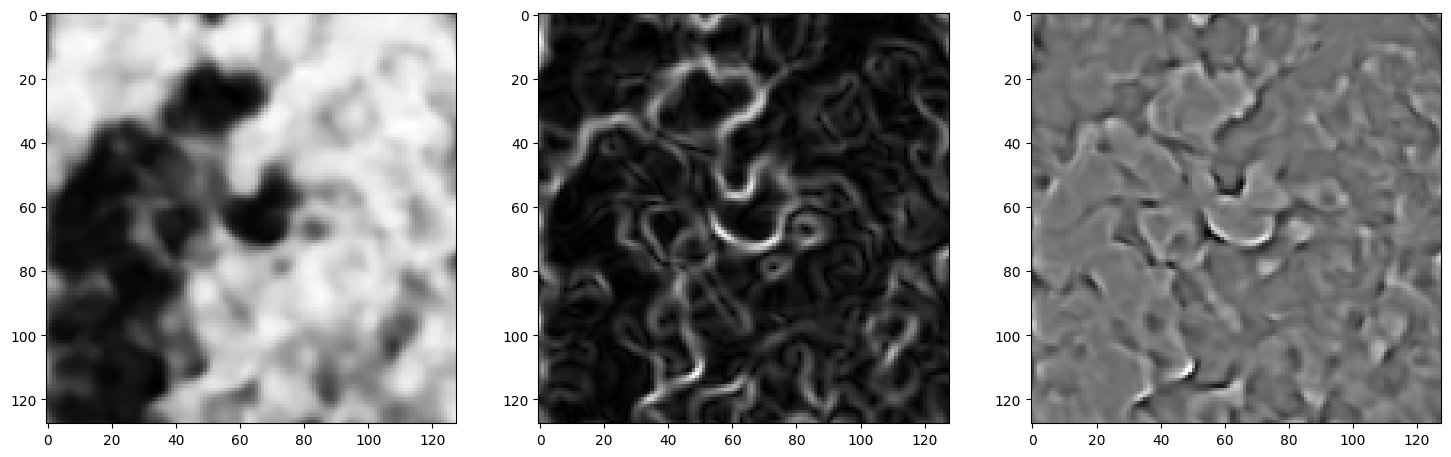

Step 20, Total loss 0.094772


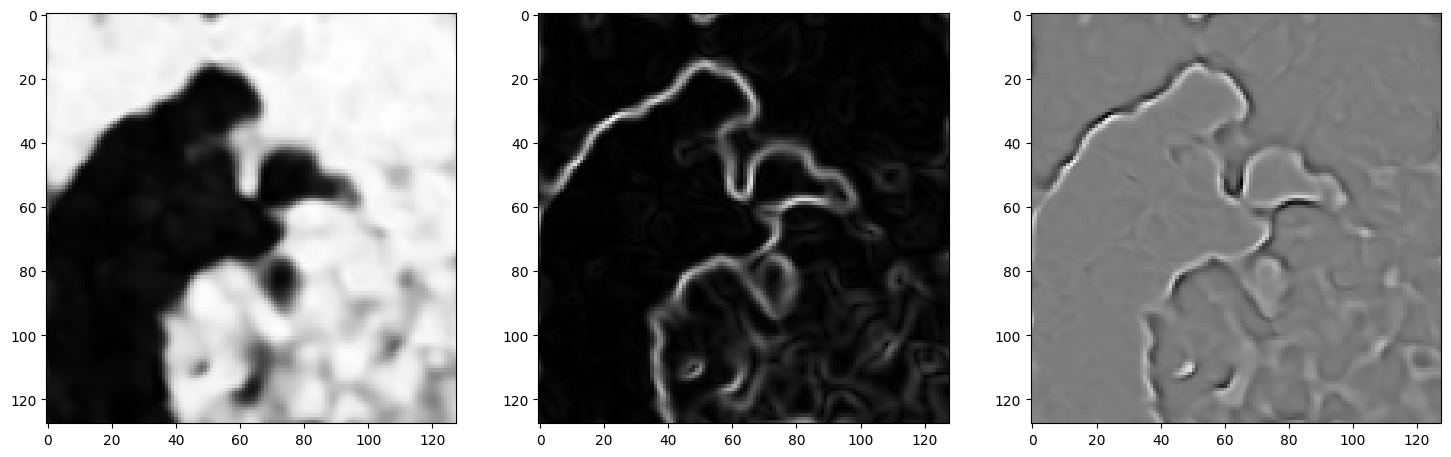

Step 30, Total loss 0.059971


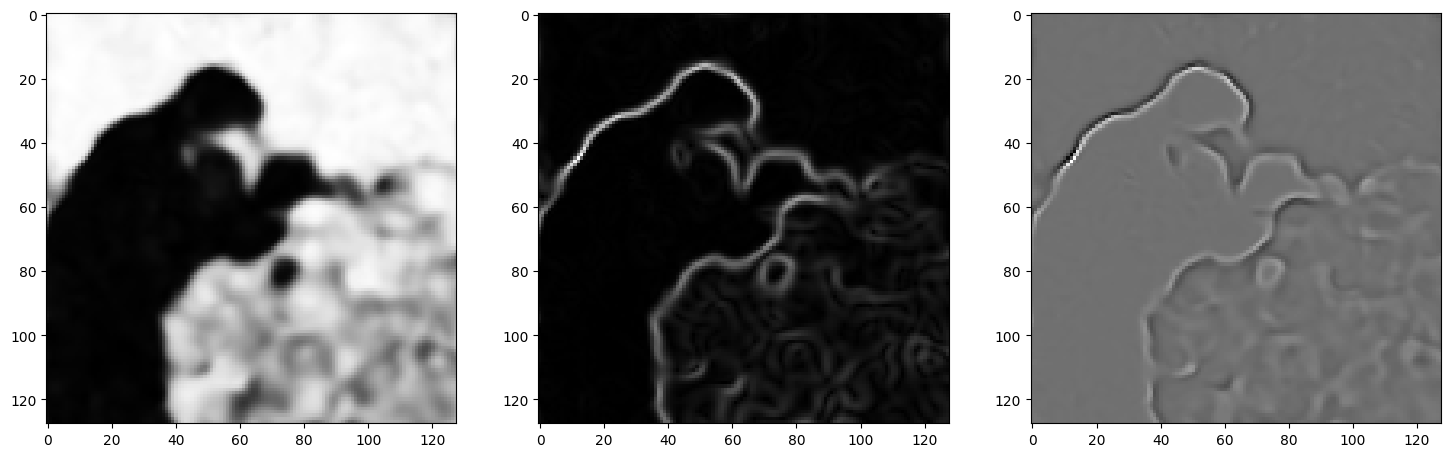

Step 40, Total loss 0.039586


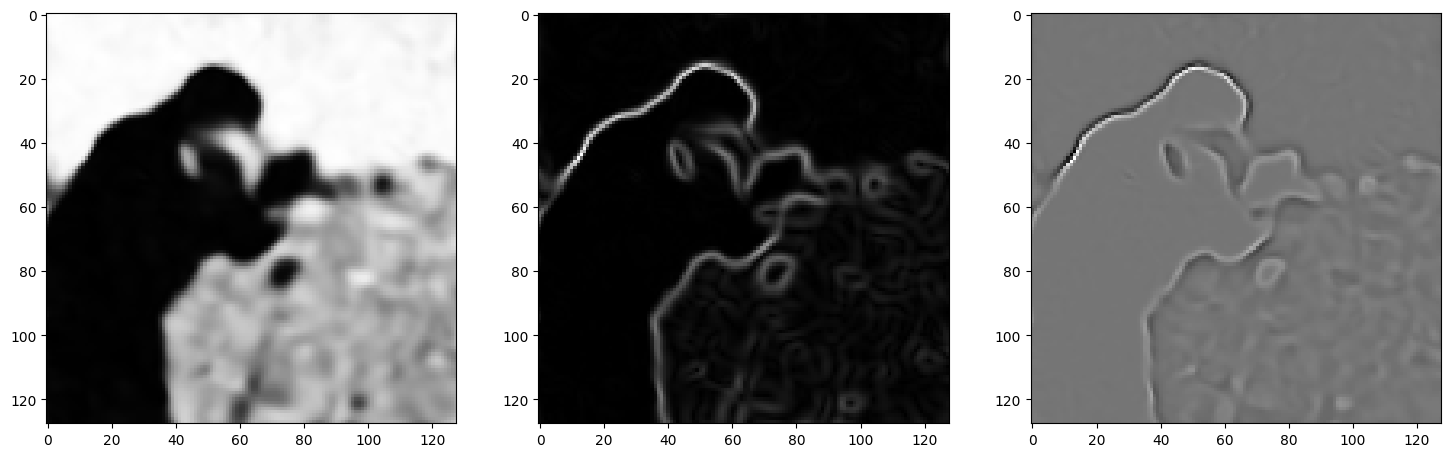

Step 50, Total loss 0.027824


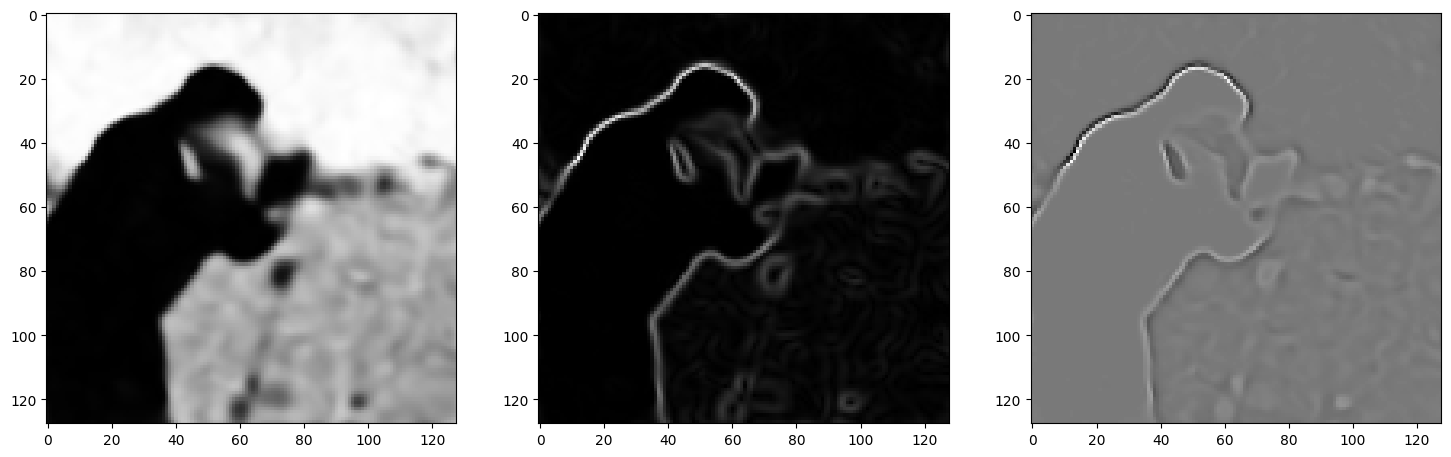

Step 60, Total loss 0.021036


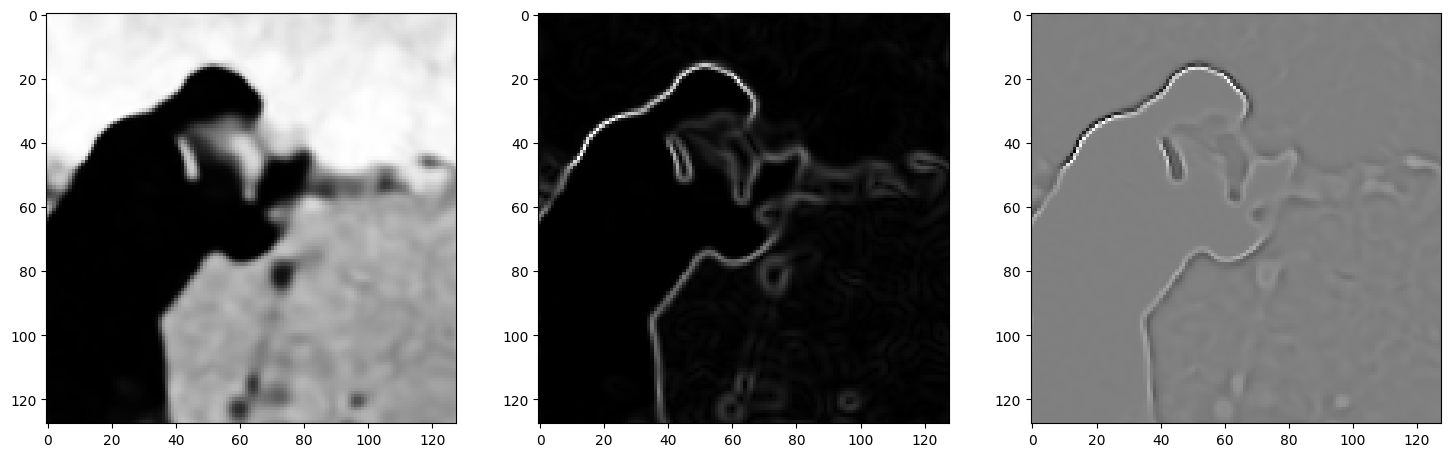

Step 70, Total loss 0.016071


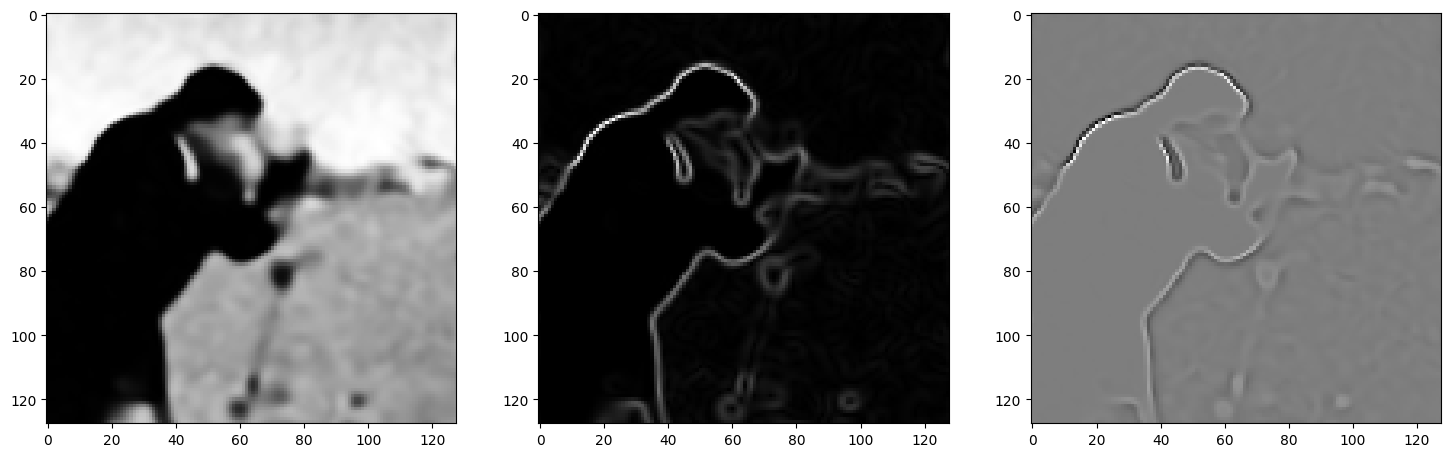

Step 80, Total loss 0.012428


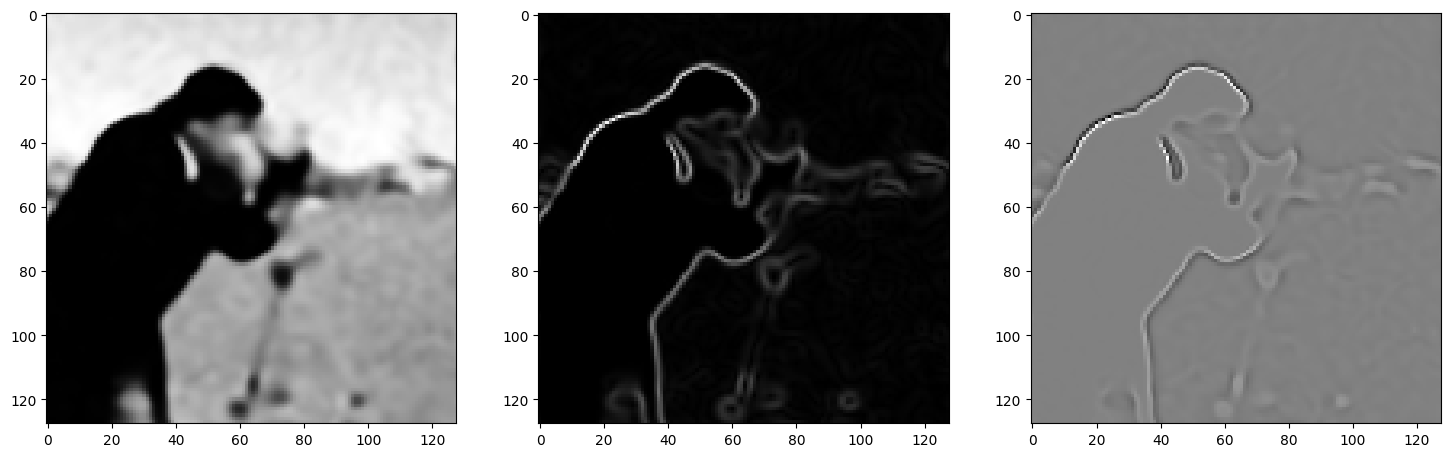

Step 90, Total loss 0.010739


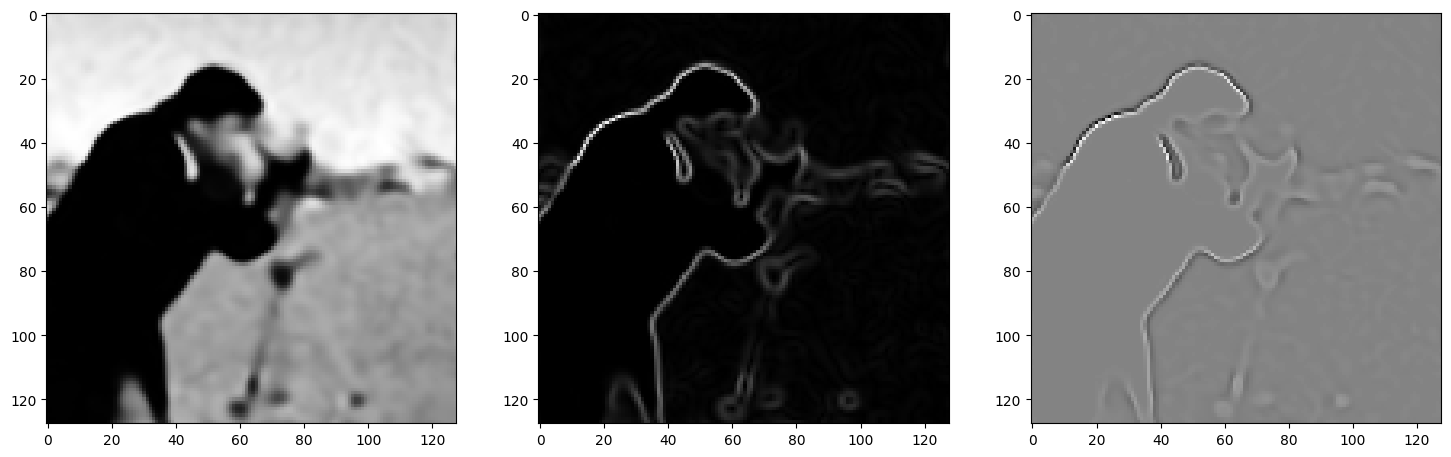

Step 100, Total loss 0.008912


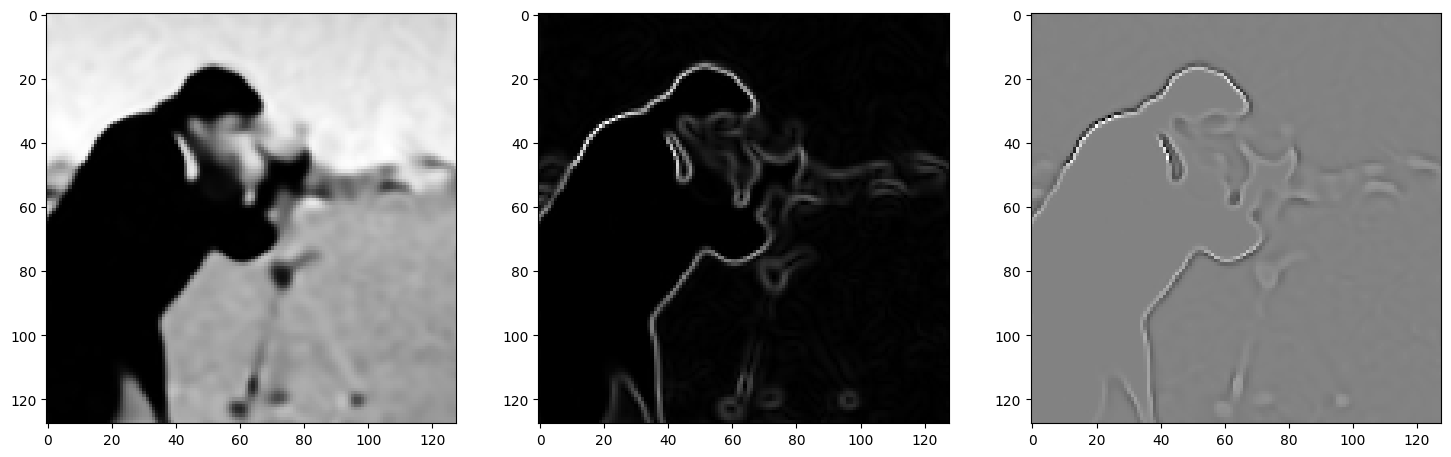

Step 110, Total loss 0.007734


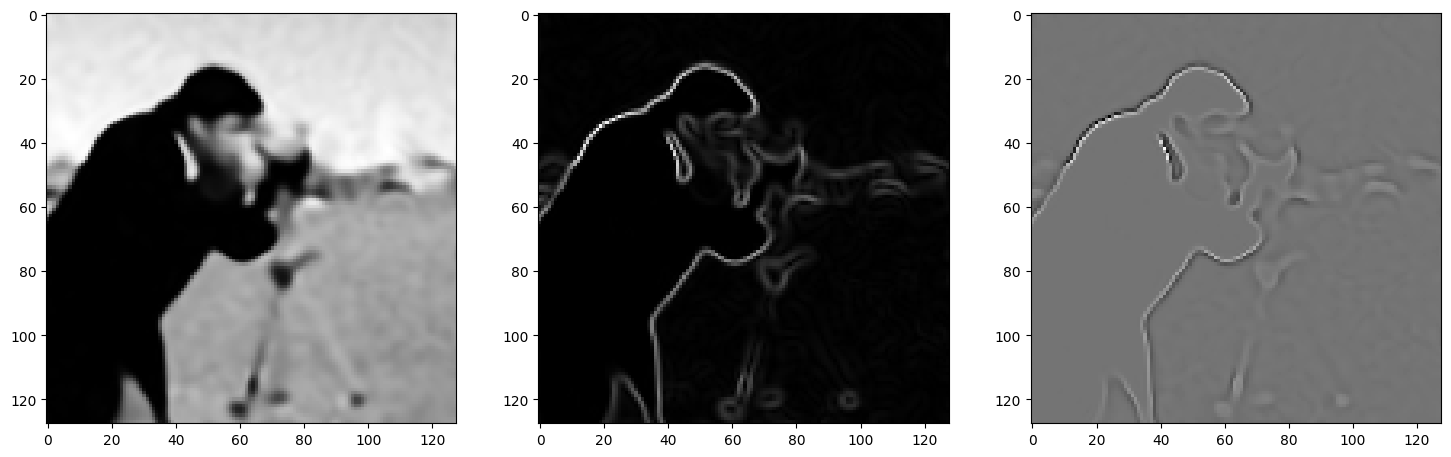

Step 120, Total loss 0.007003


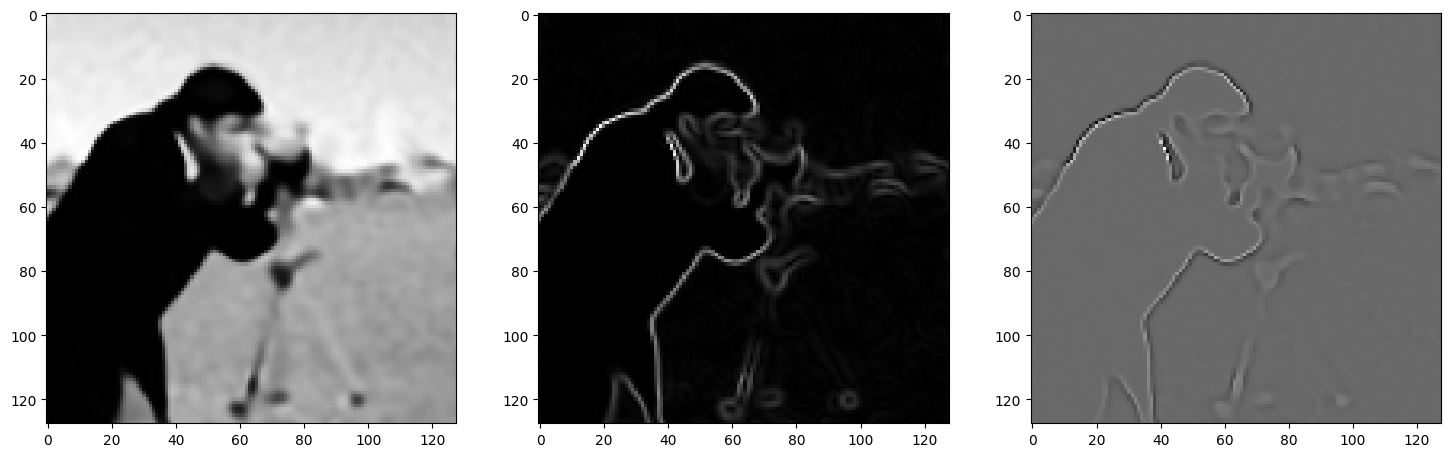

Step 130, Total loss 0.006430


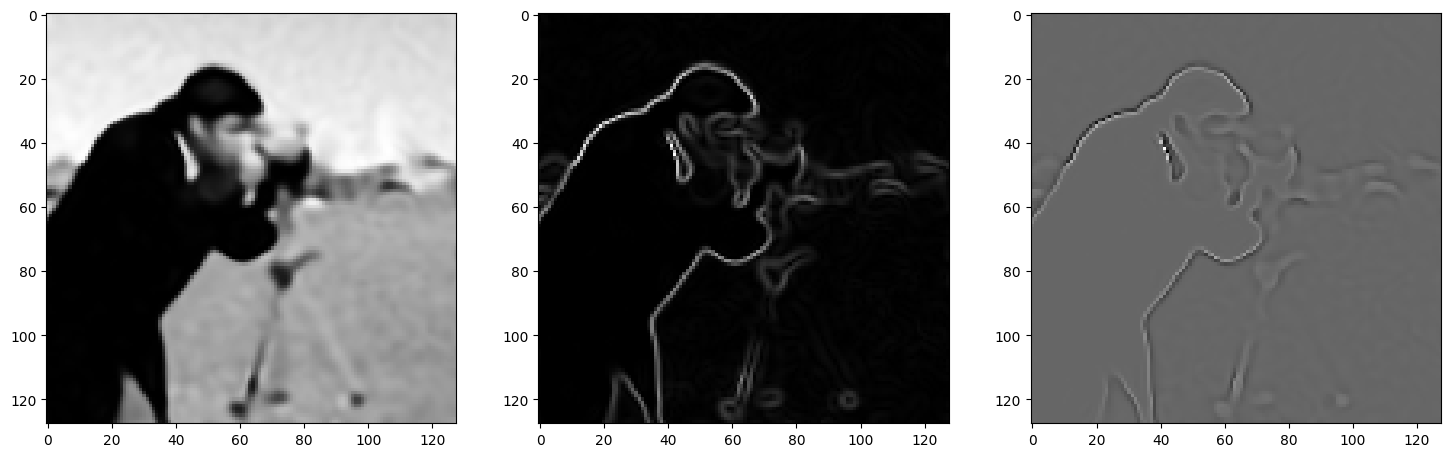

Step 140, Total loss 0.005988


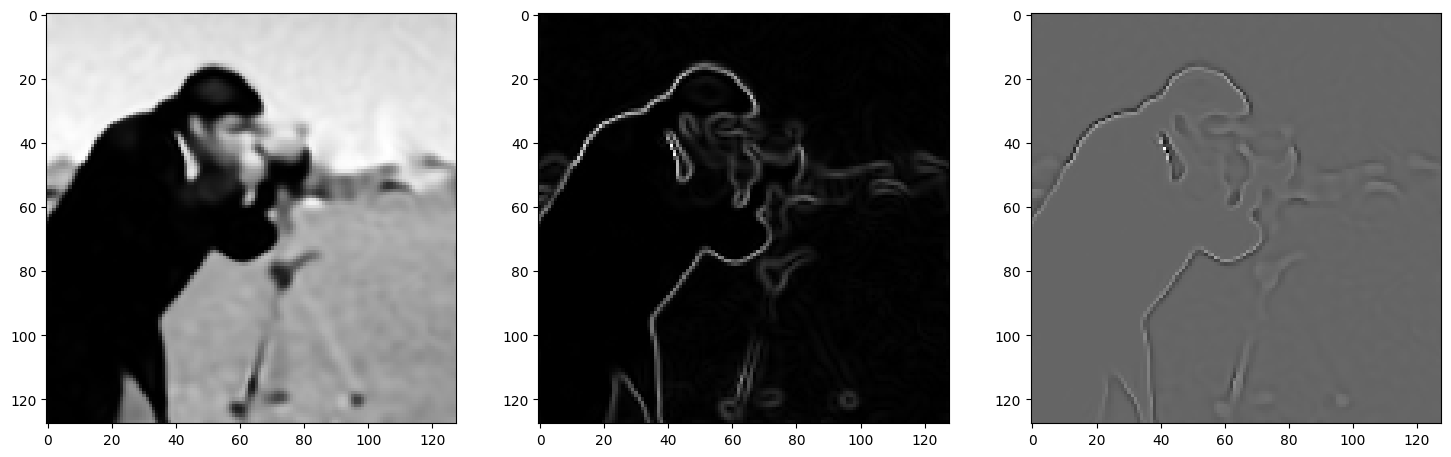

Step 150, Total loss 0.005622


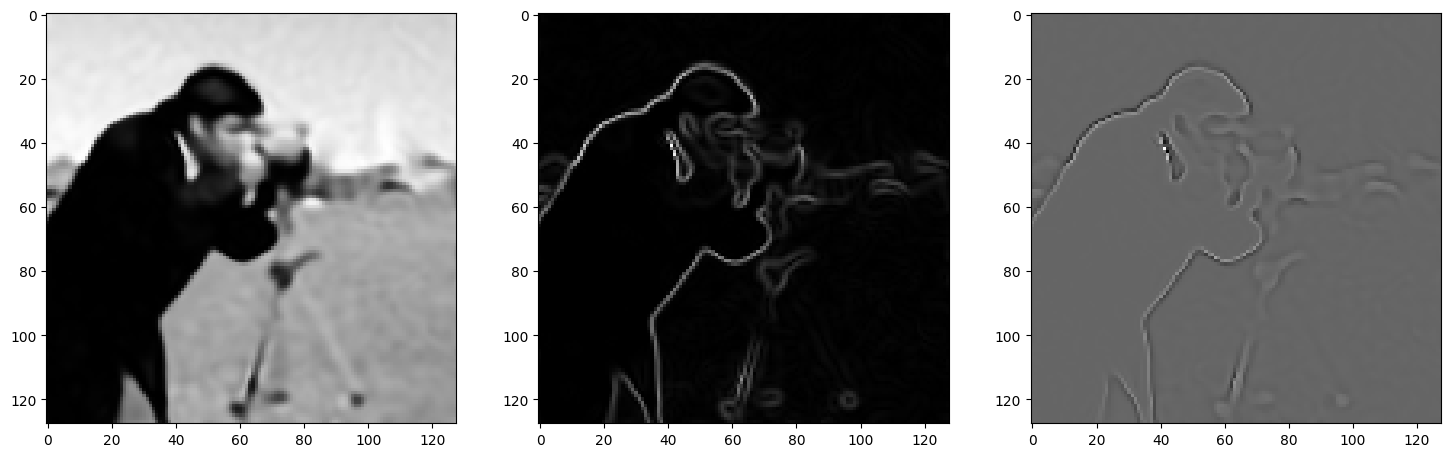

Step 160, Total loss 0.005293


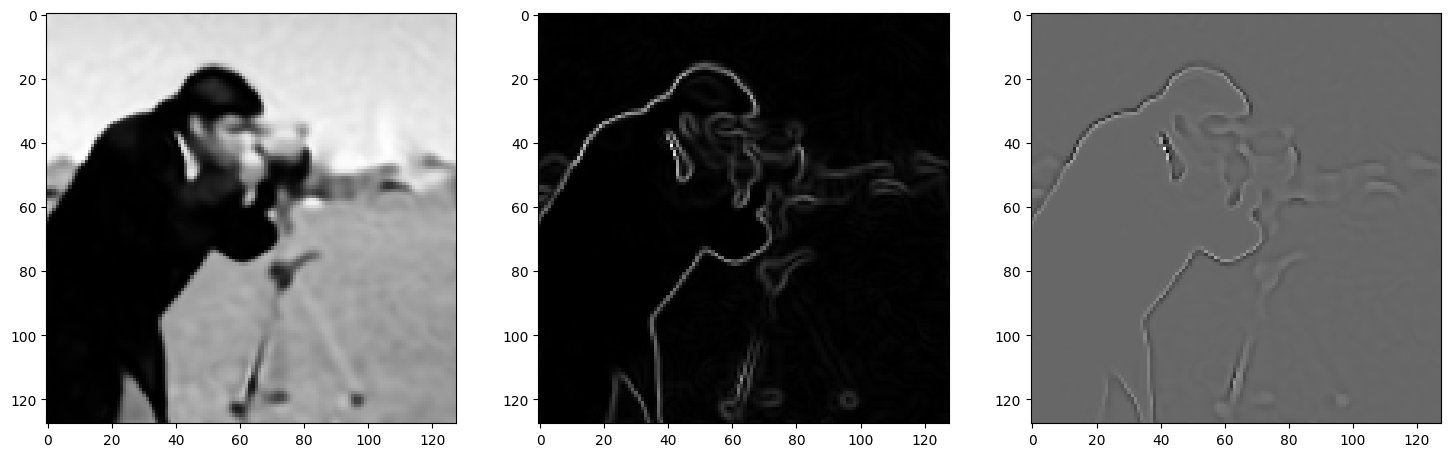

Step 170, Total loss 0.004975


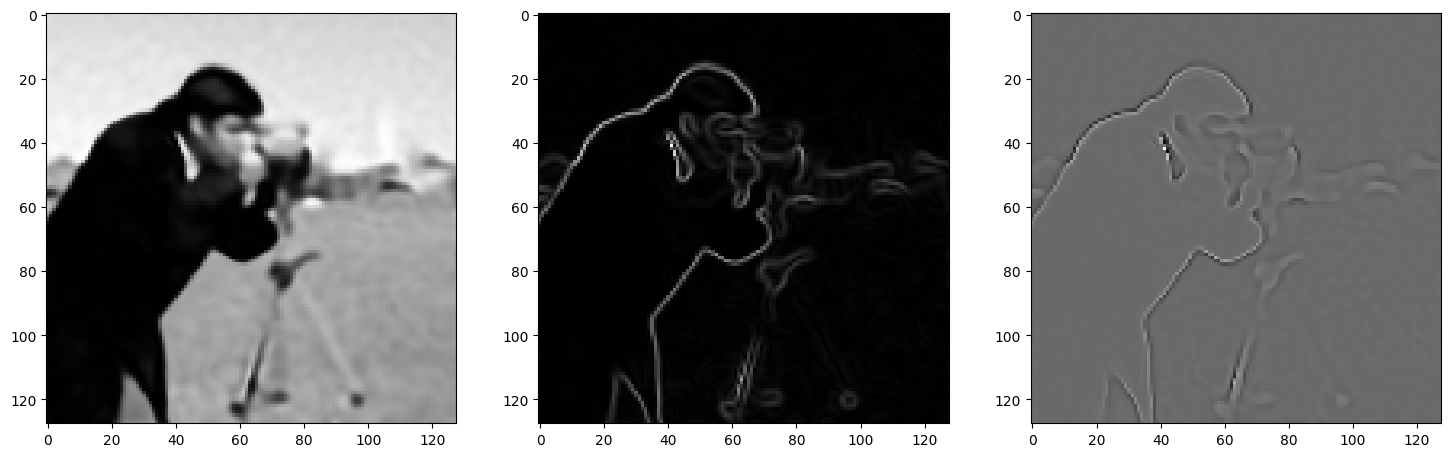

Step 180, Total loss 0.004685


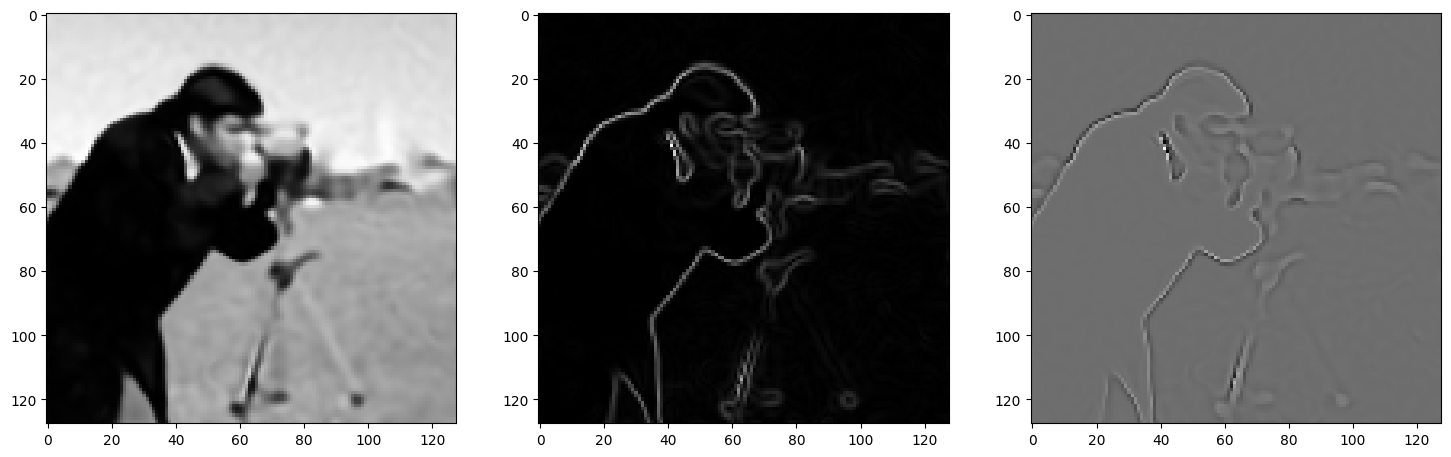

Step 190, Total loss 0.004438


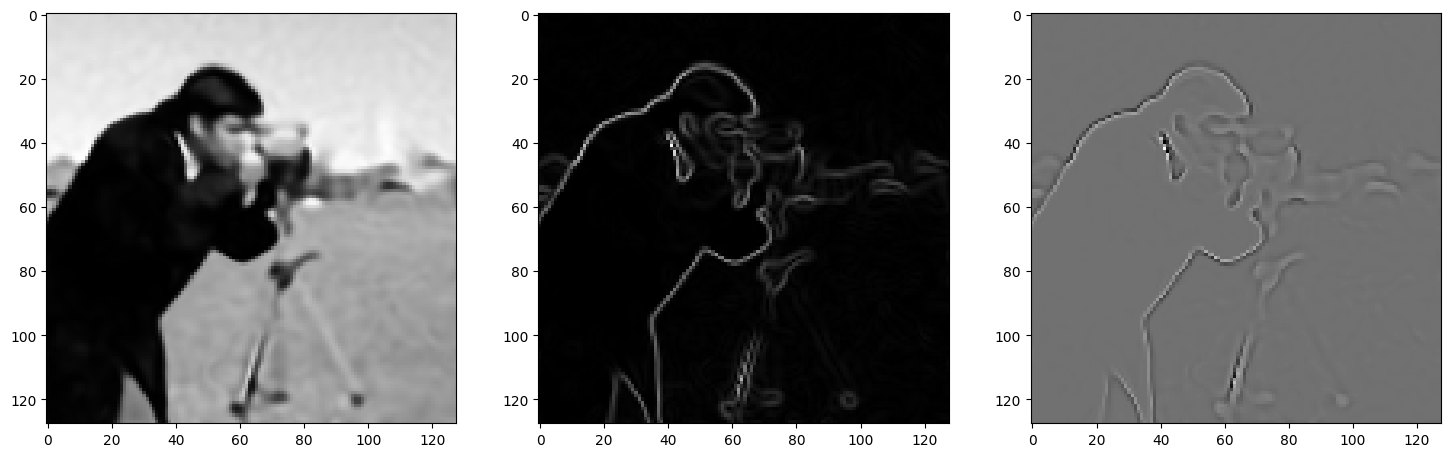

Step 200, Total loss 0.004194


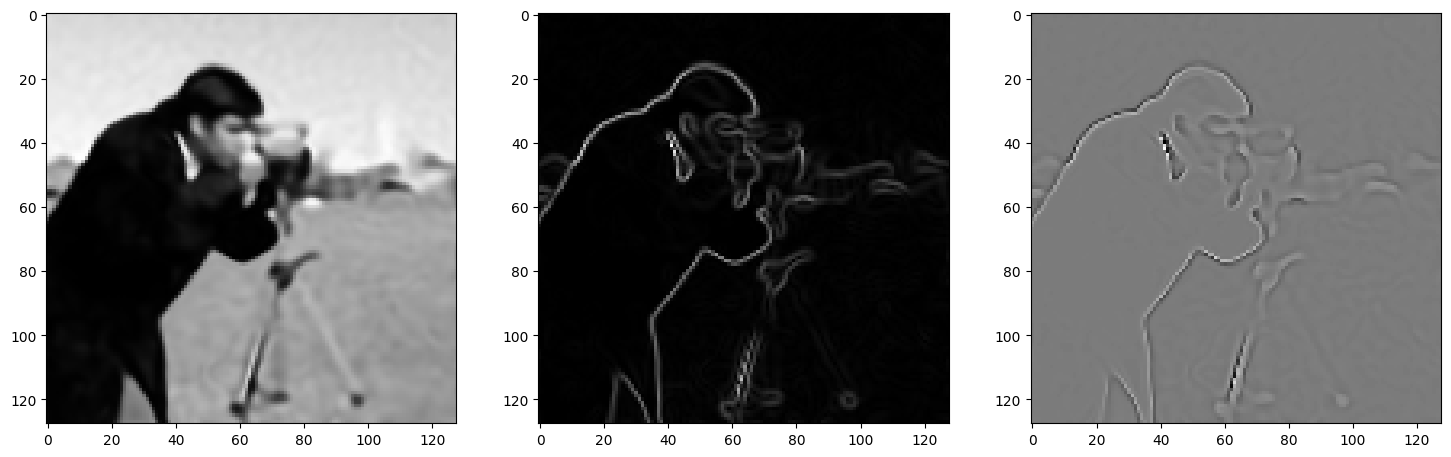

Step 210, Total loss 0.003975


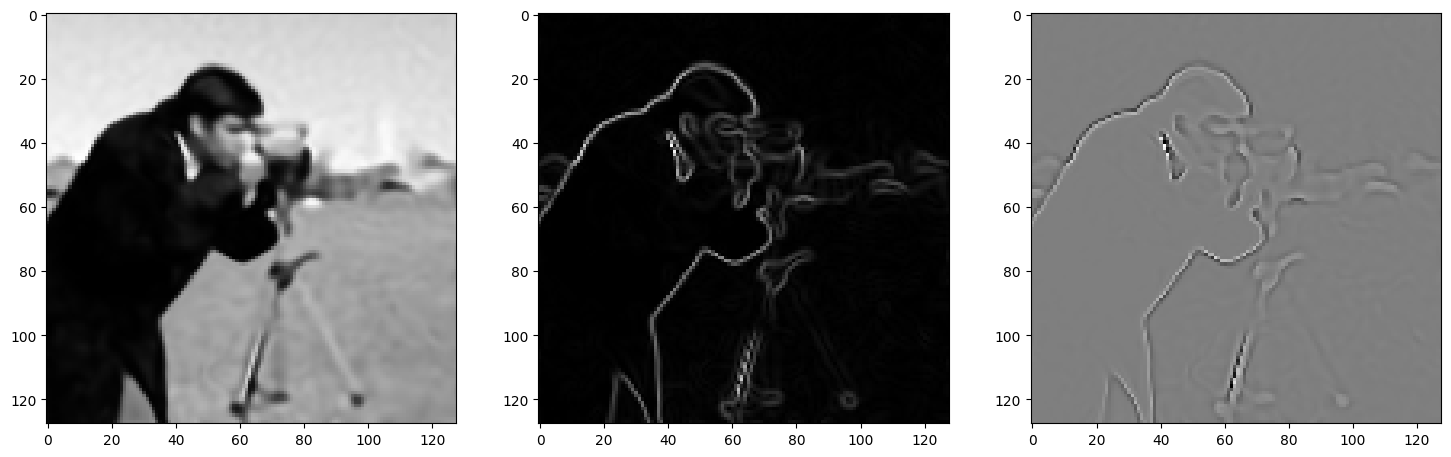

Step 220, Total loss 0.003756


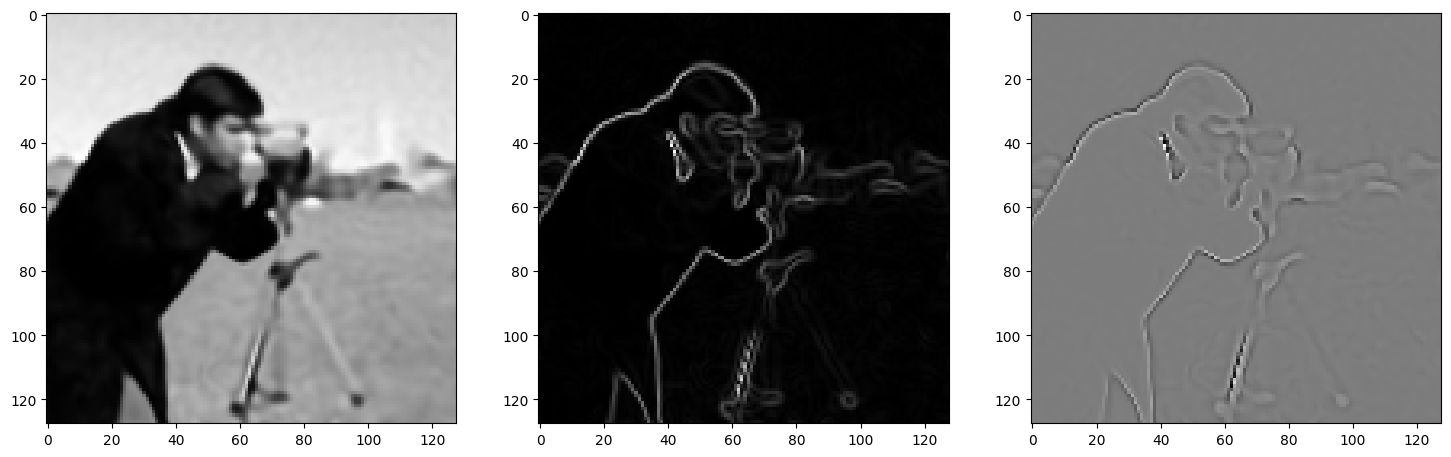

Step 230, Total loss 0.003539


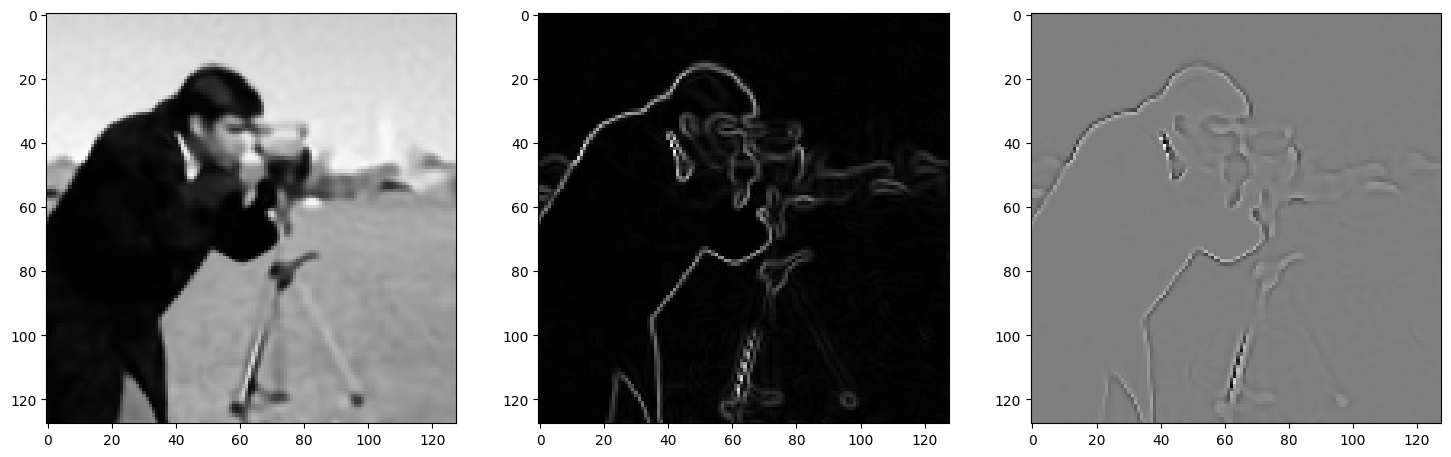

Step 240, Total loss 0.003343


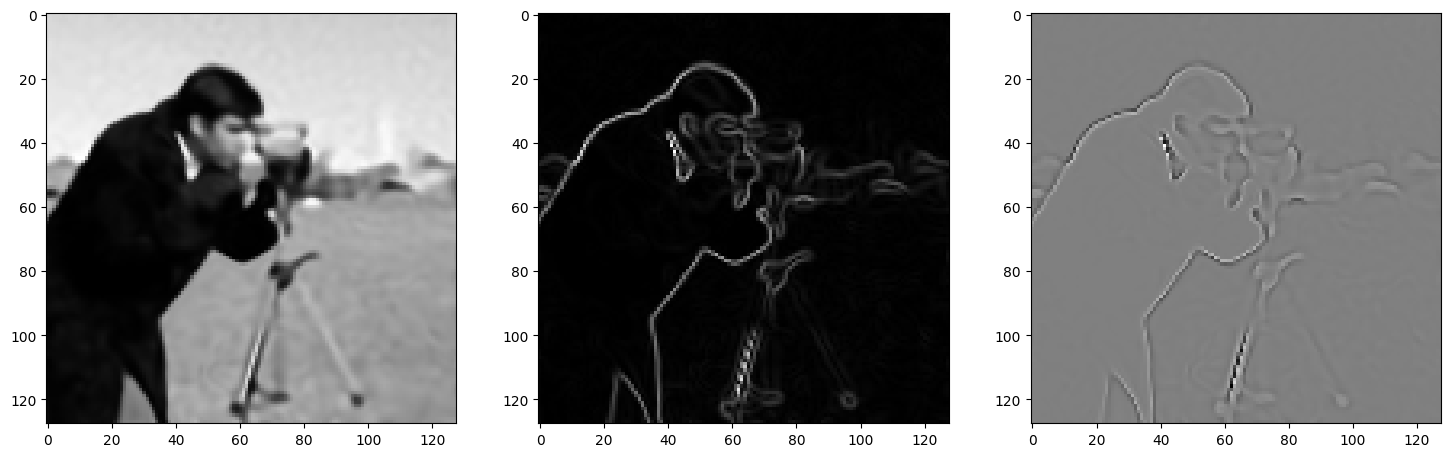

Step 250, Total loss 0.003176


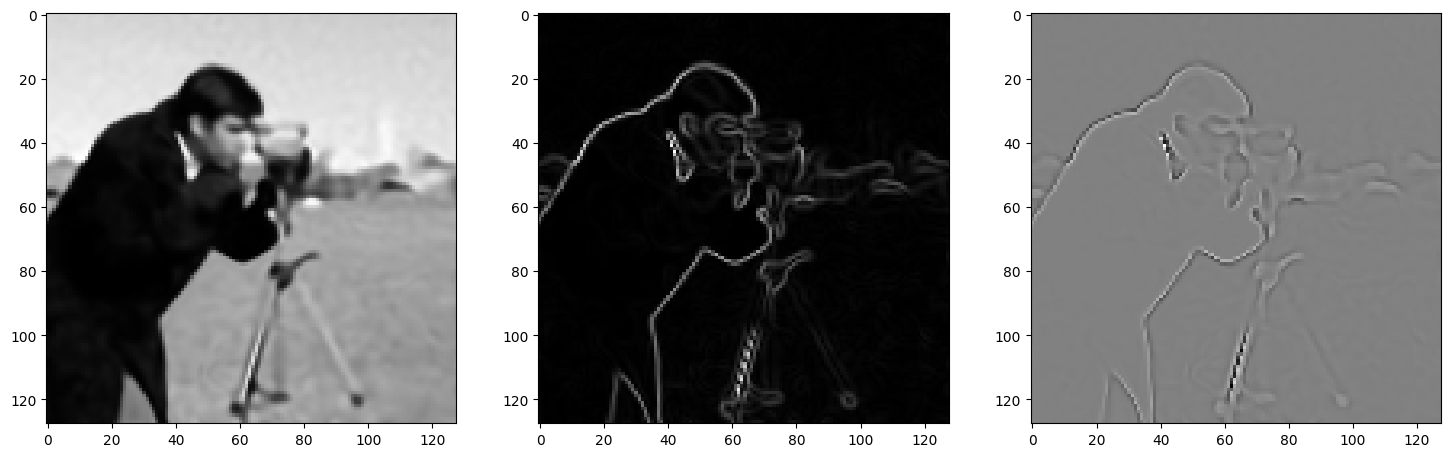

Step 260, Total loss 0.003017


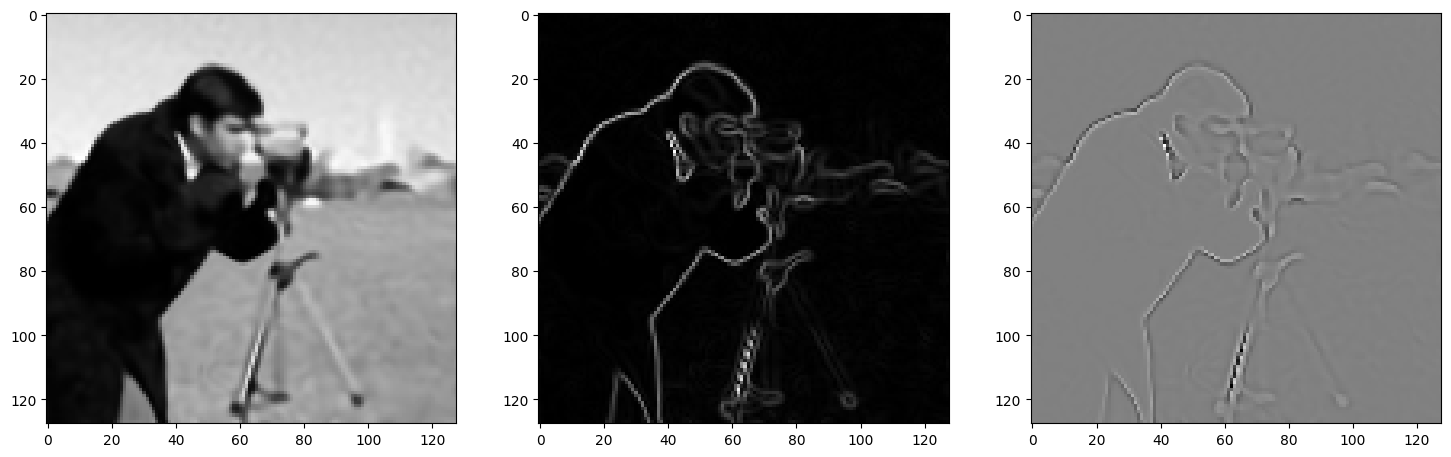

Step 270, Total loss 0.002873


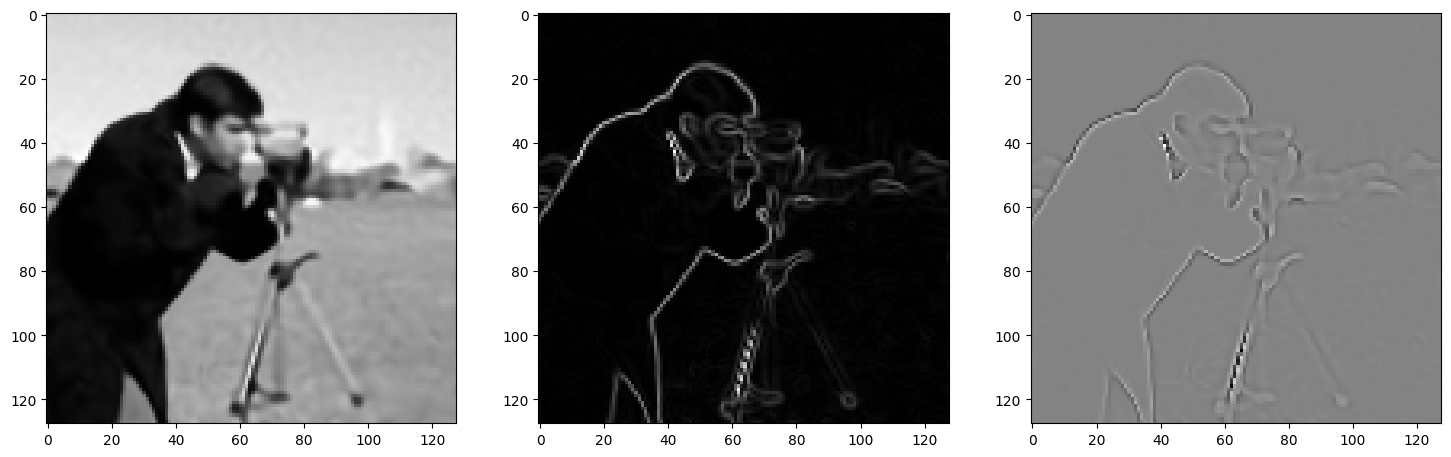

Step 280, Total loss 0.002859


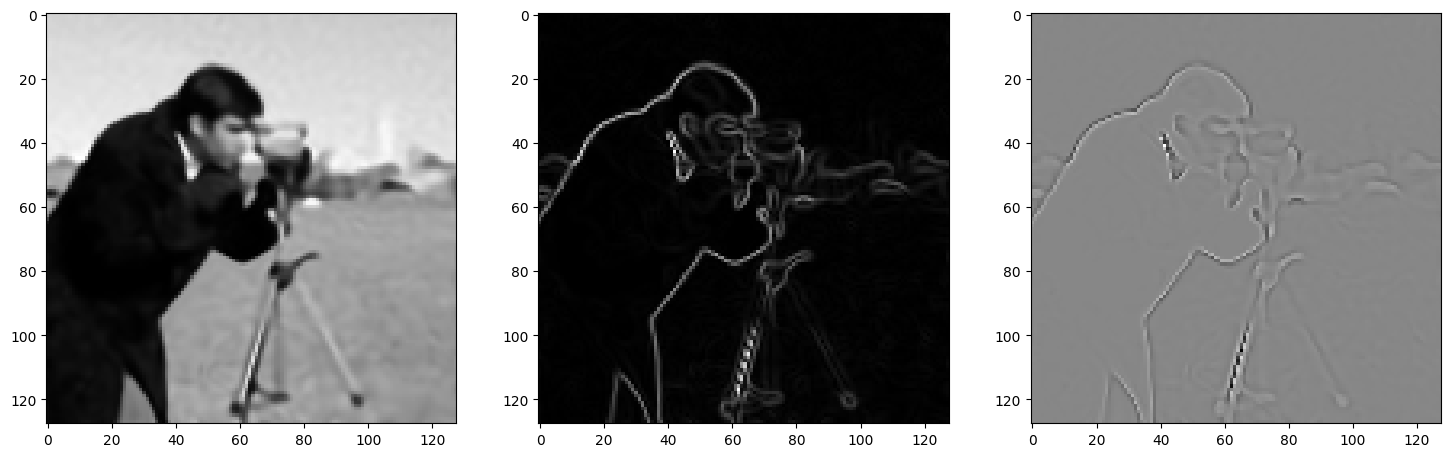

Step 290, Total loss 0.002702


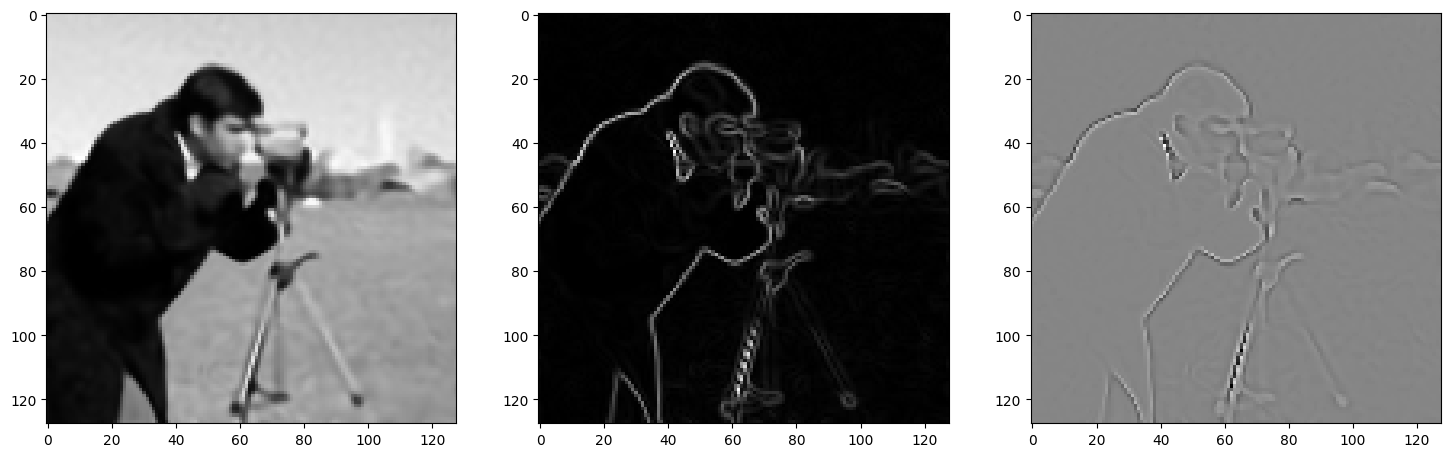

Step 300, Total loss 0.002475


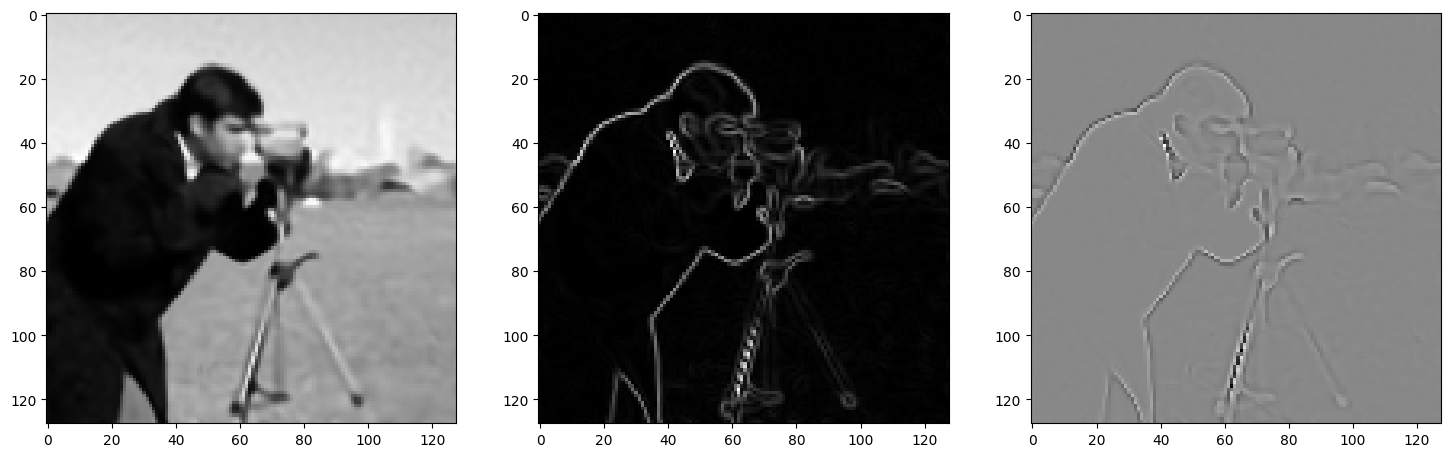

Step 310, Total loss 0.002352


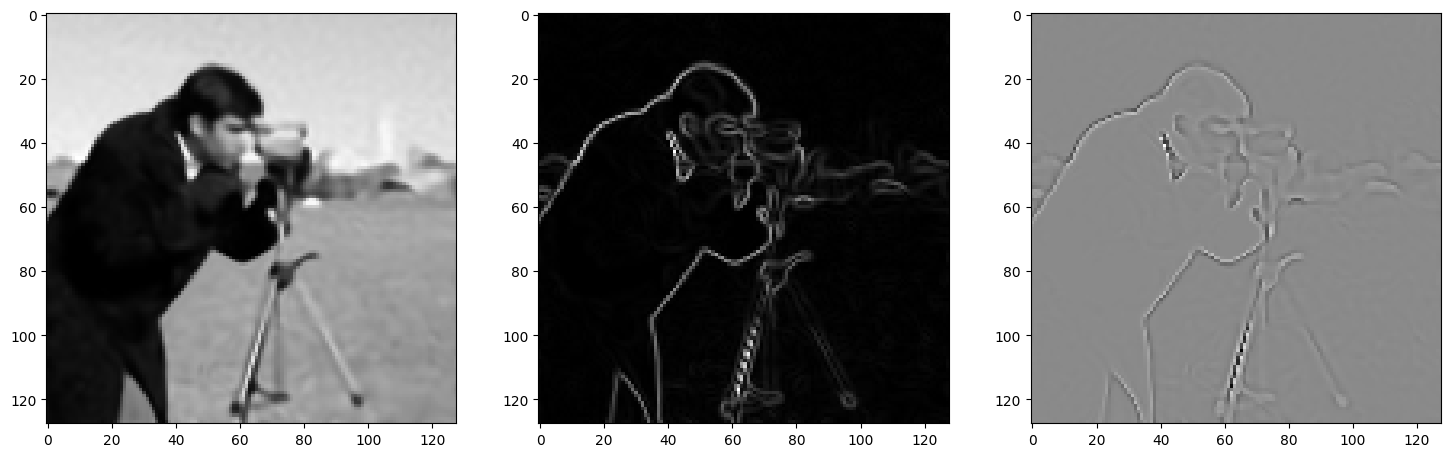

Step 320, Total loss 0.002226


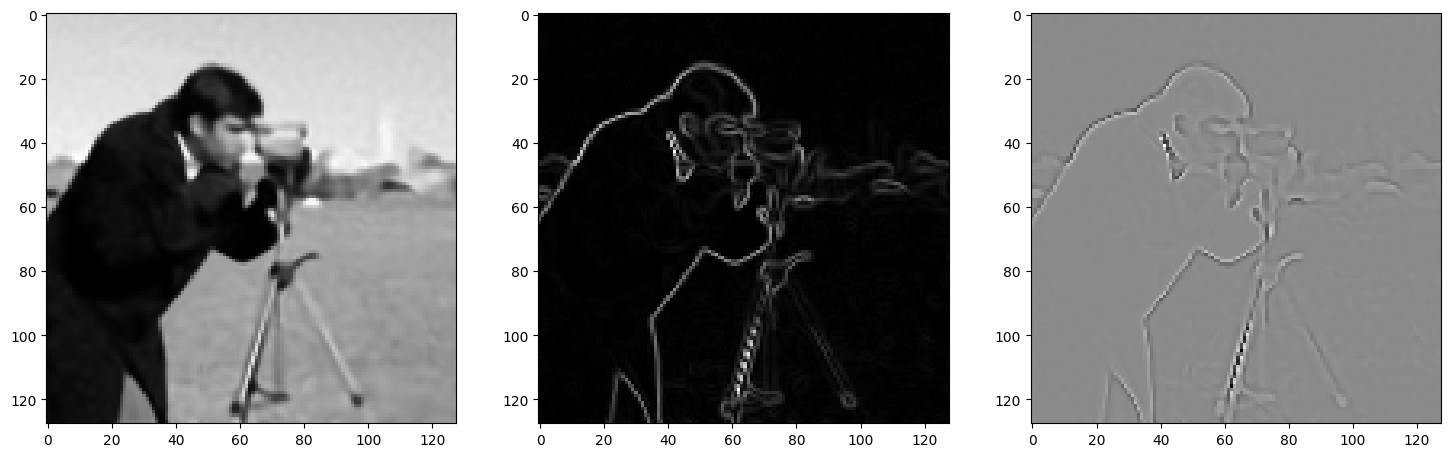

Step 330, Total loss 0.002107


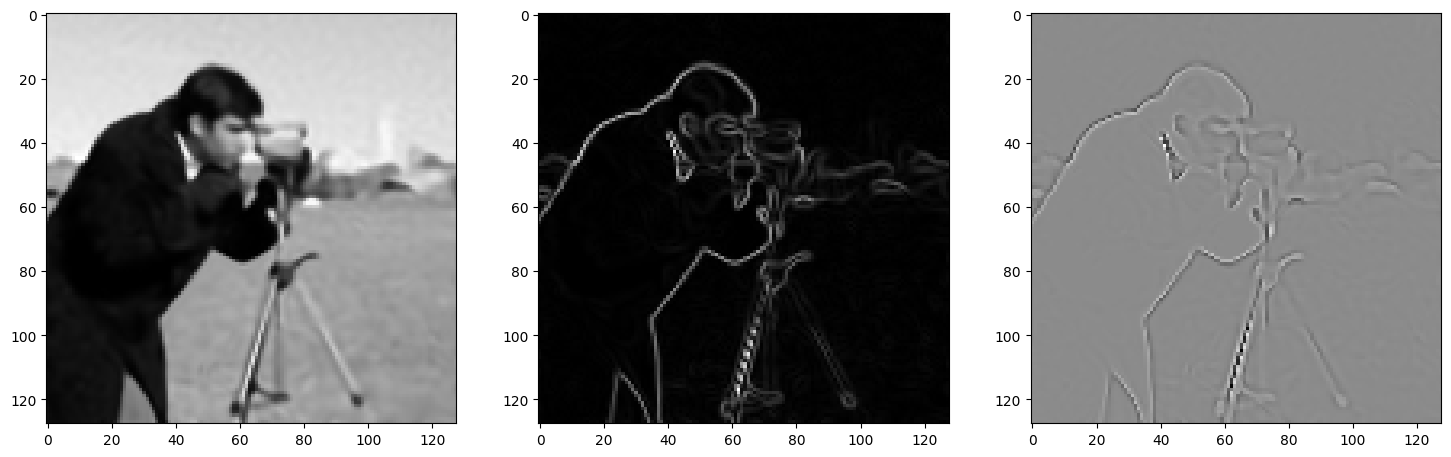

Step 340, Total loss 0.001993


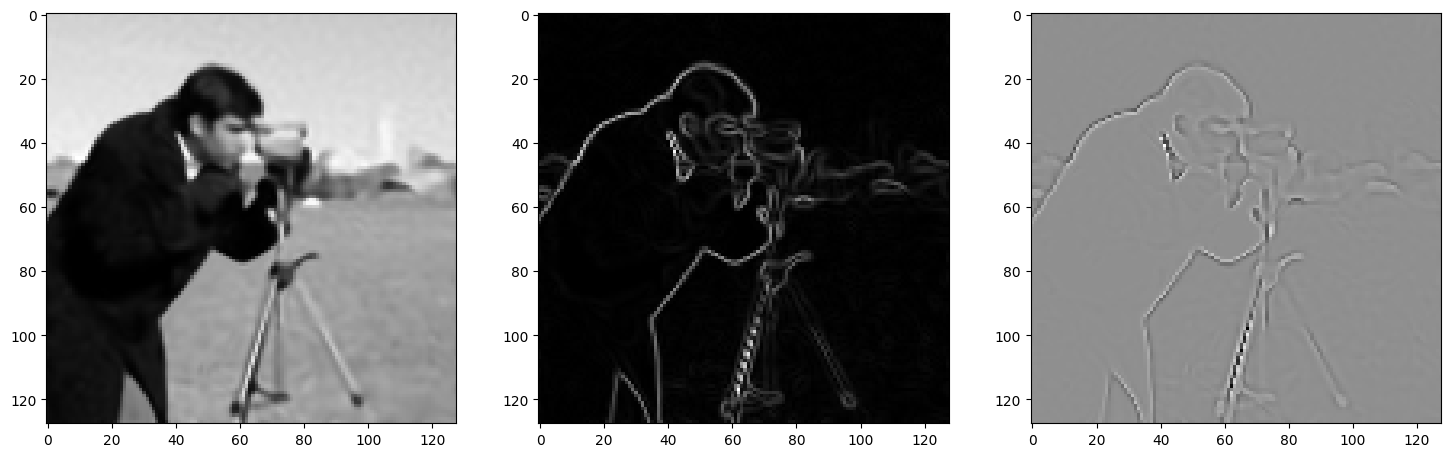

Step 350, Total loss 0.001891


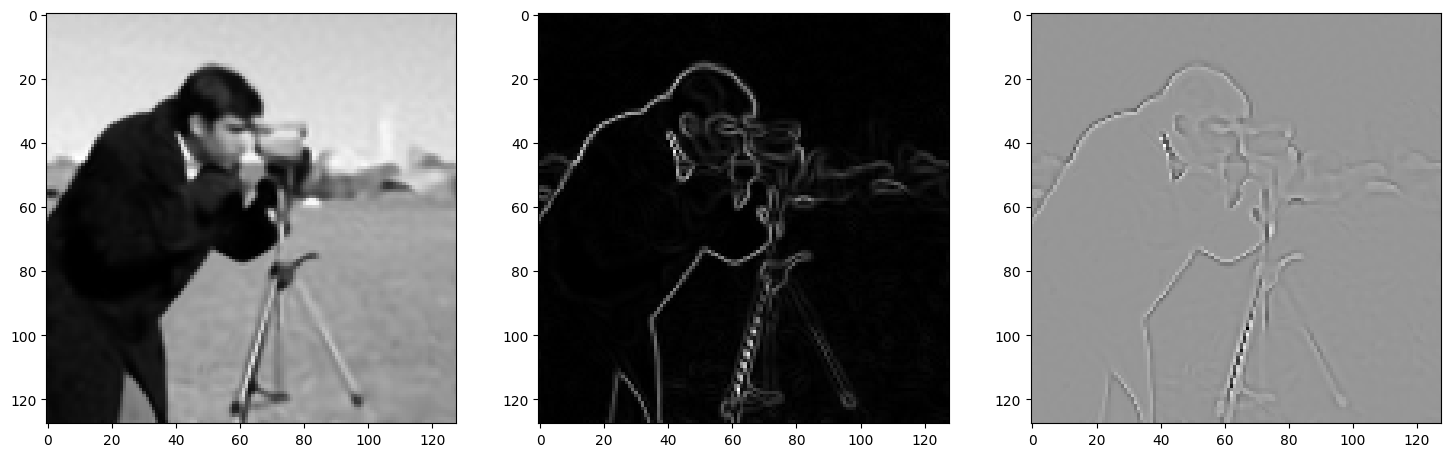

Step 360, Total loss 0.001985


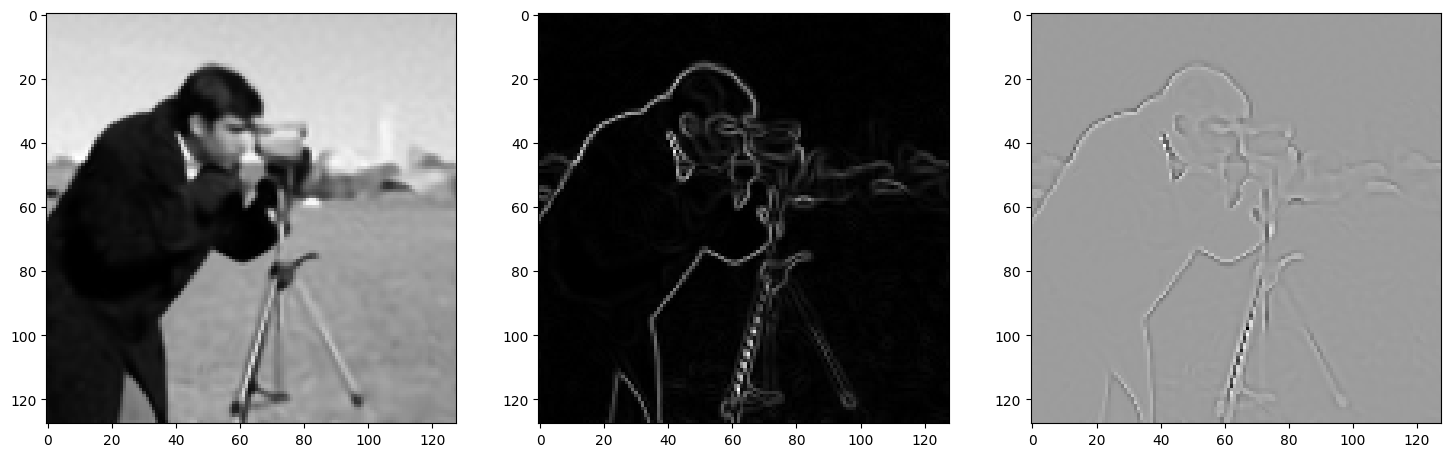

Step 370, Total loss 0.001823


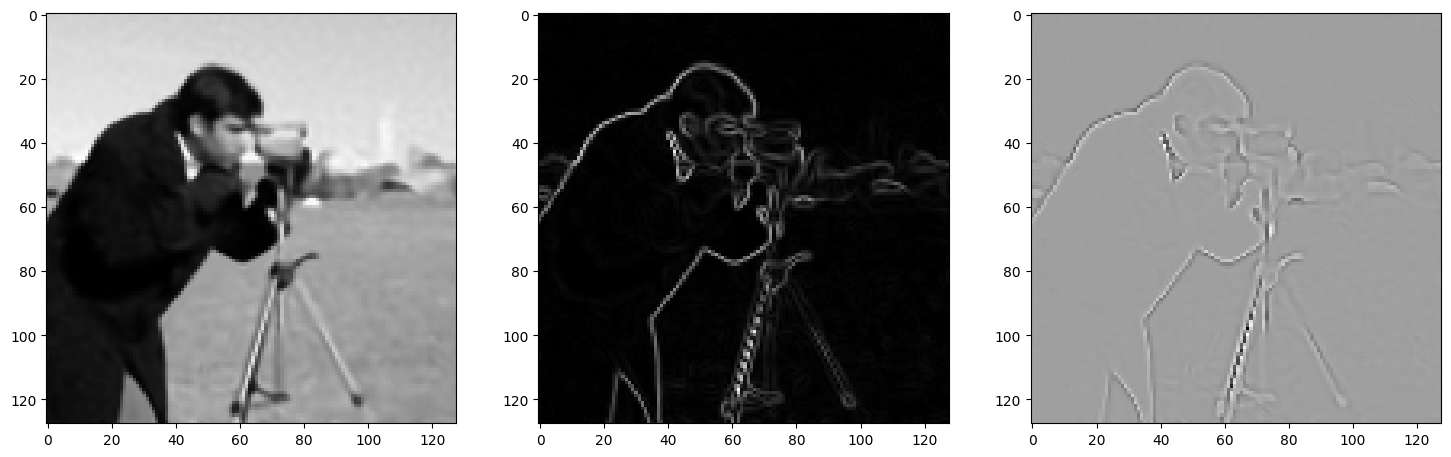

Step 380, Total loss 0.001662


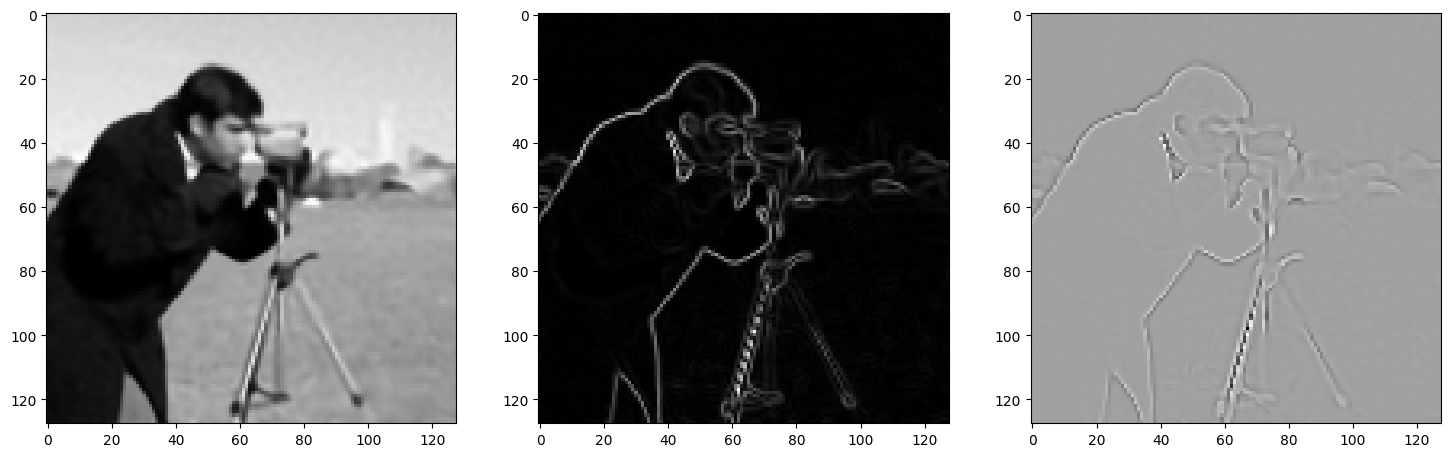

Step 390, Total loss 0.001552


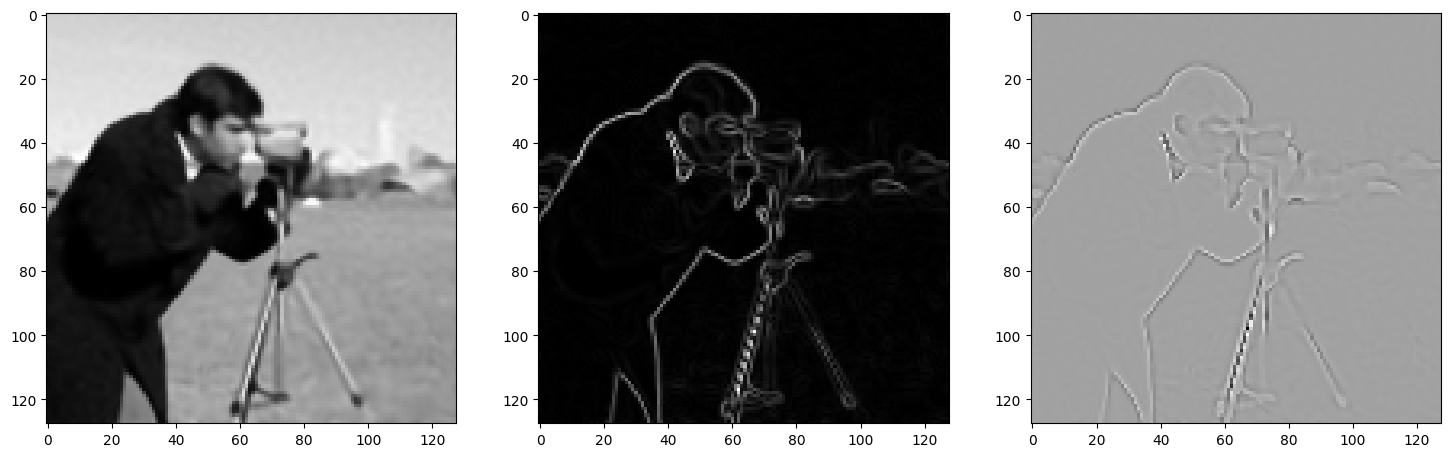

Step 400, Total loss 0.001491


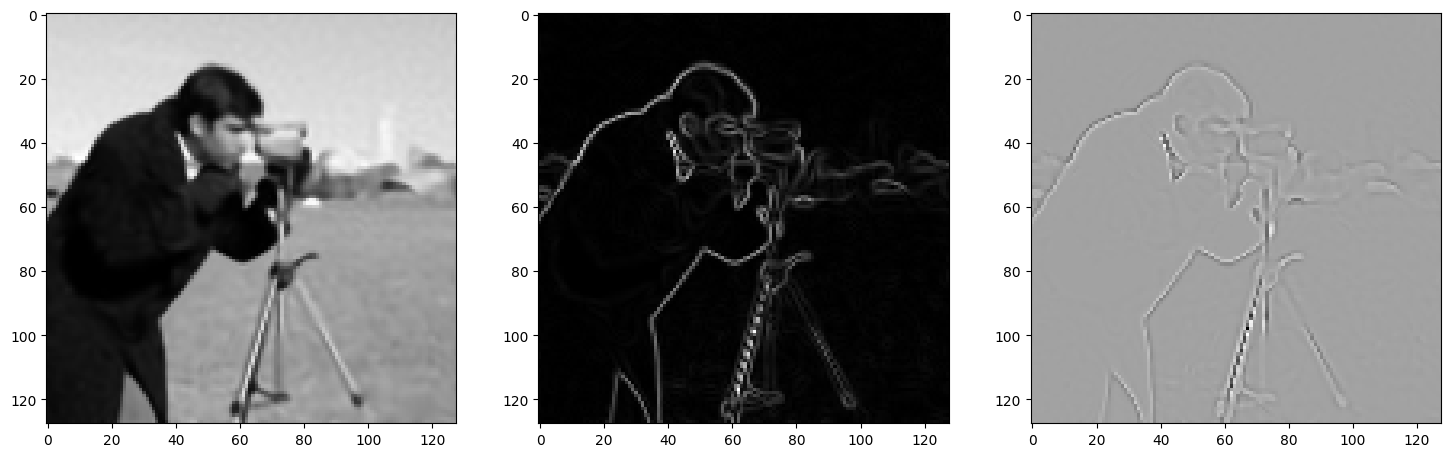

Step 410, Total loss 0.001423


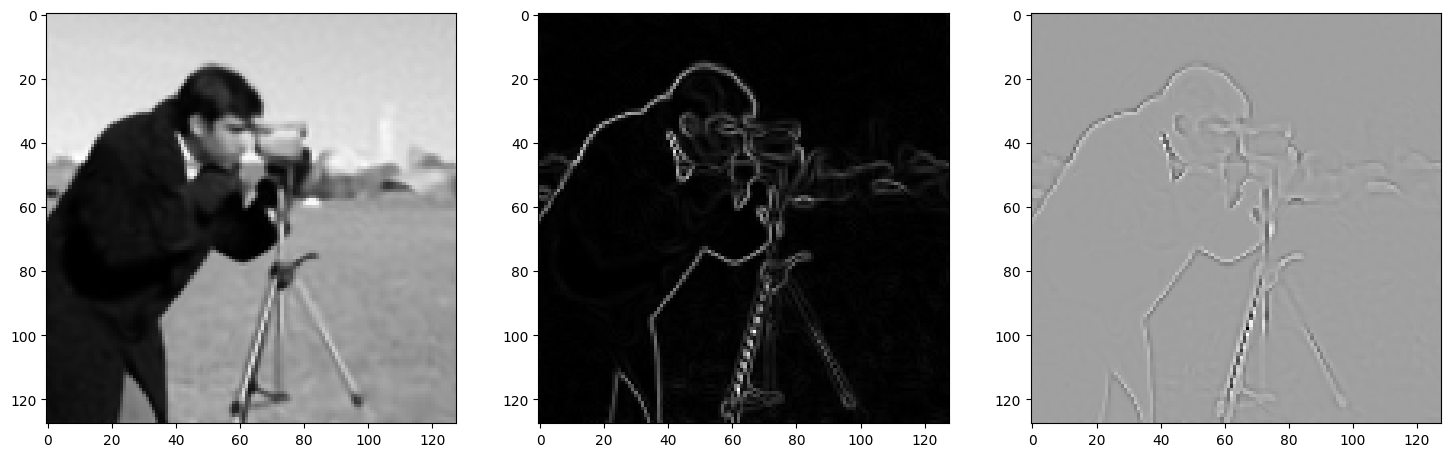

Step 420, Total loss 0.001365


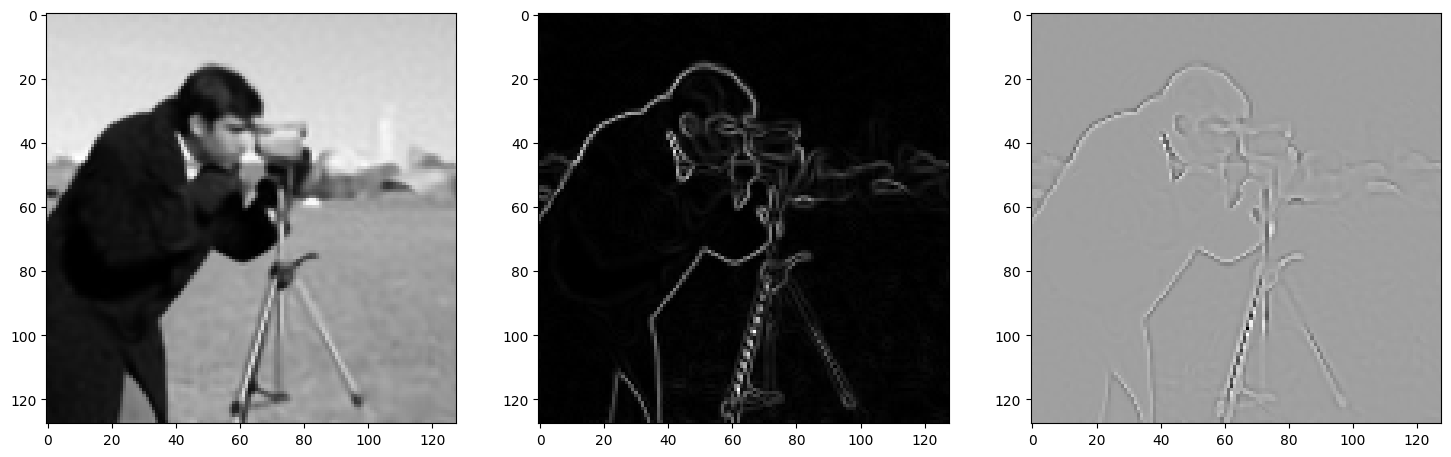

Step 430, Total loss 0.001311


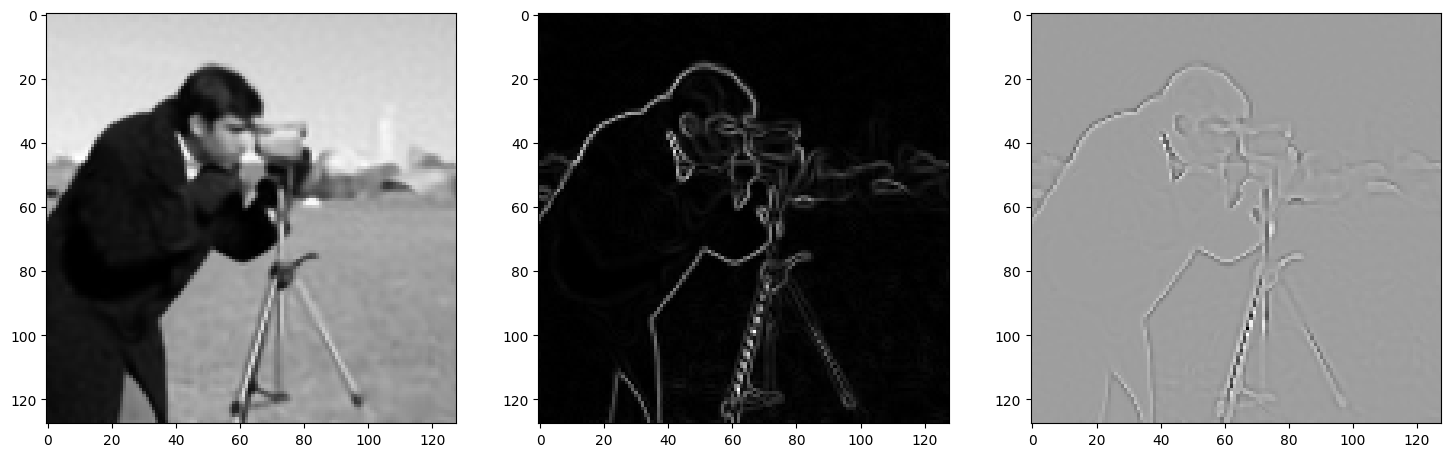

Step 440, Total loss 0.001282


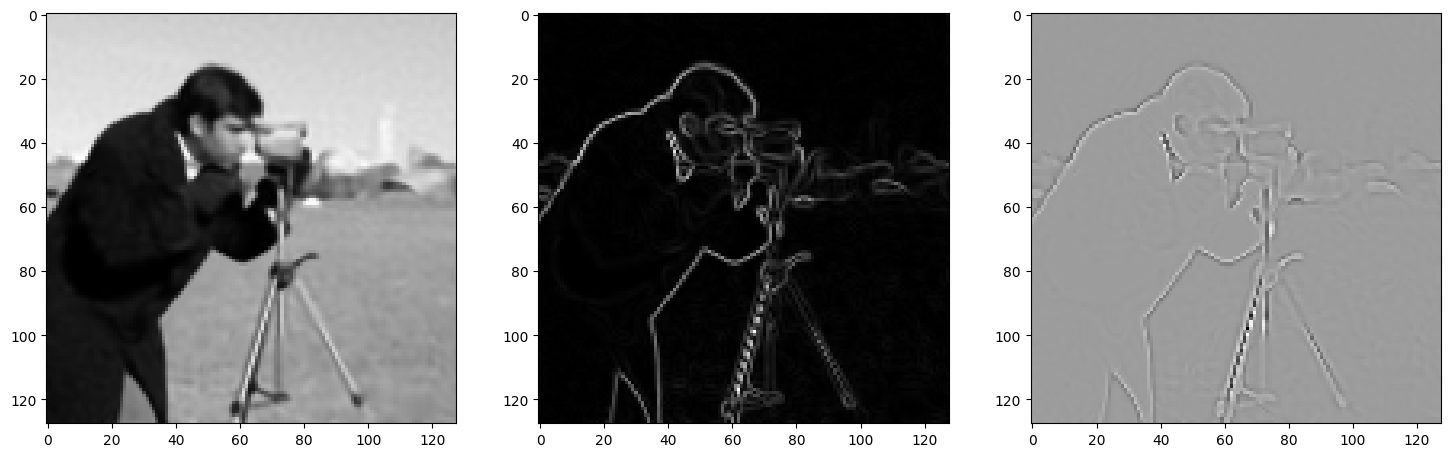

Step 450, Total loss 0.001372


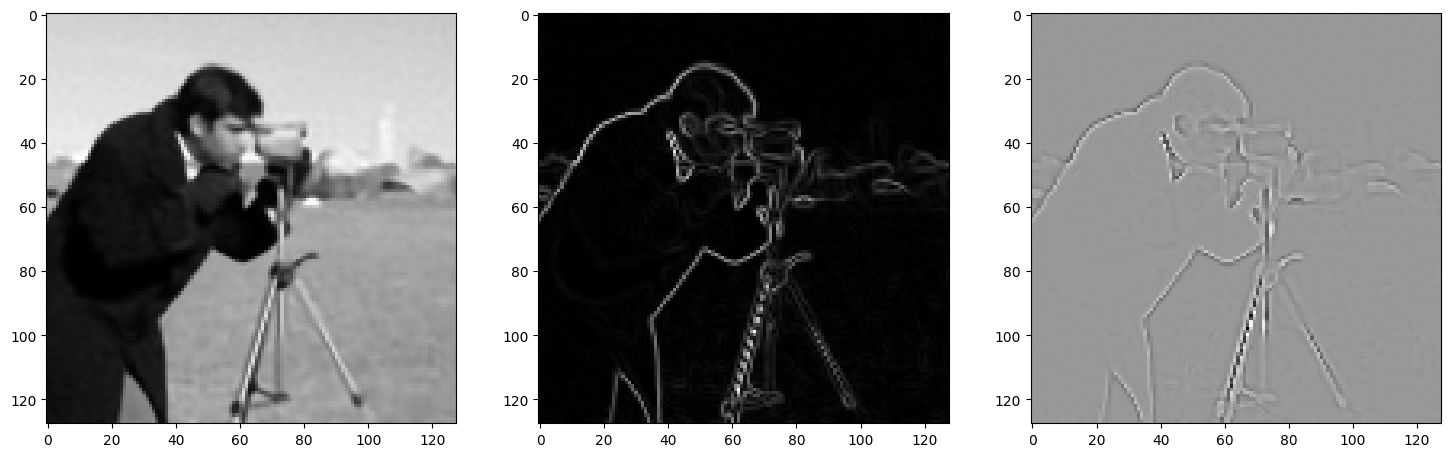

Step 460, Total loss 0.001246


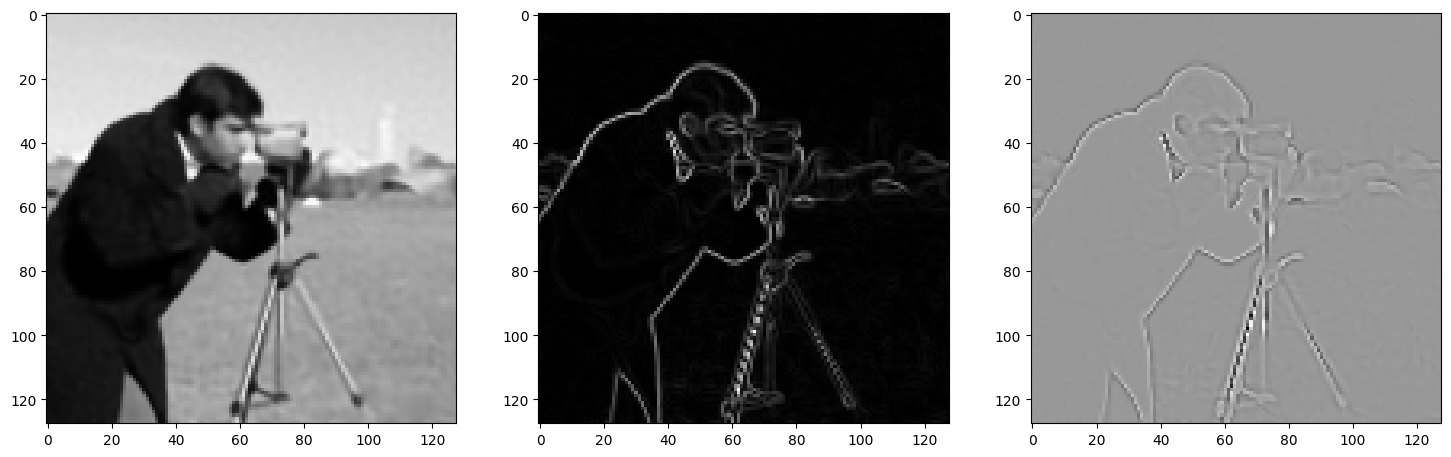

Step 470, Total loss 0.001142


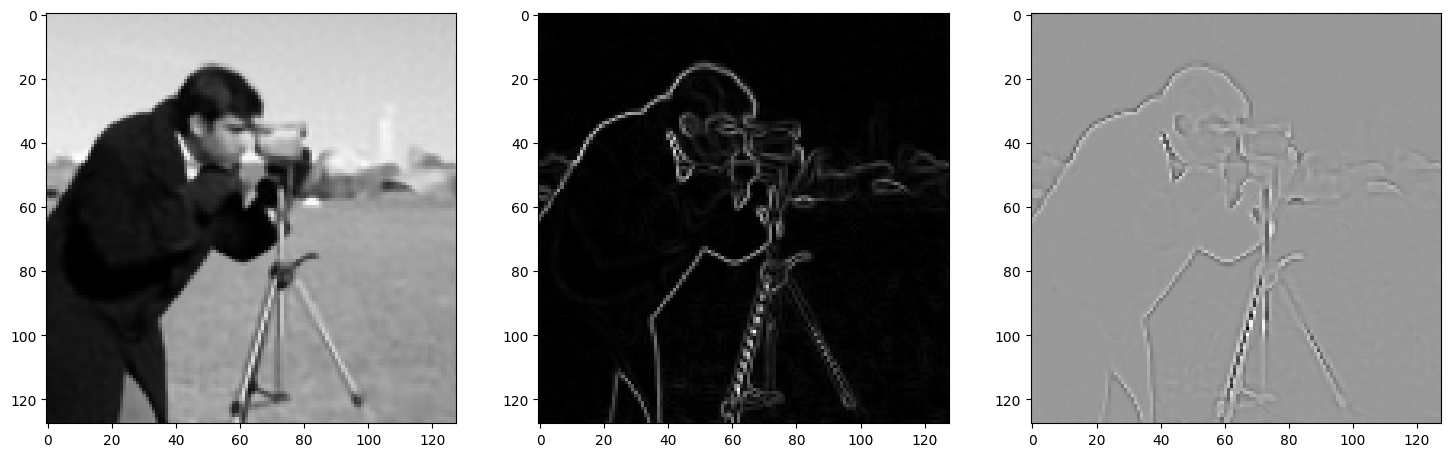

Step 480, Total loss 0.001089


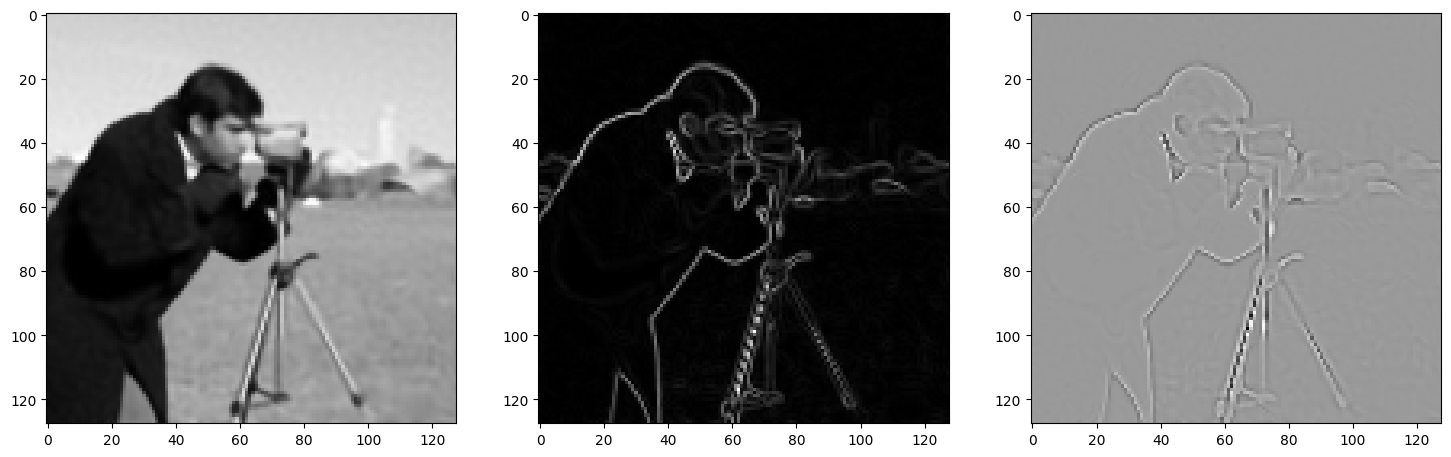

Step 490, Total loss 0.001054


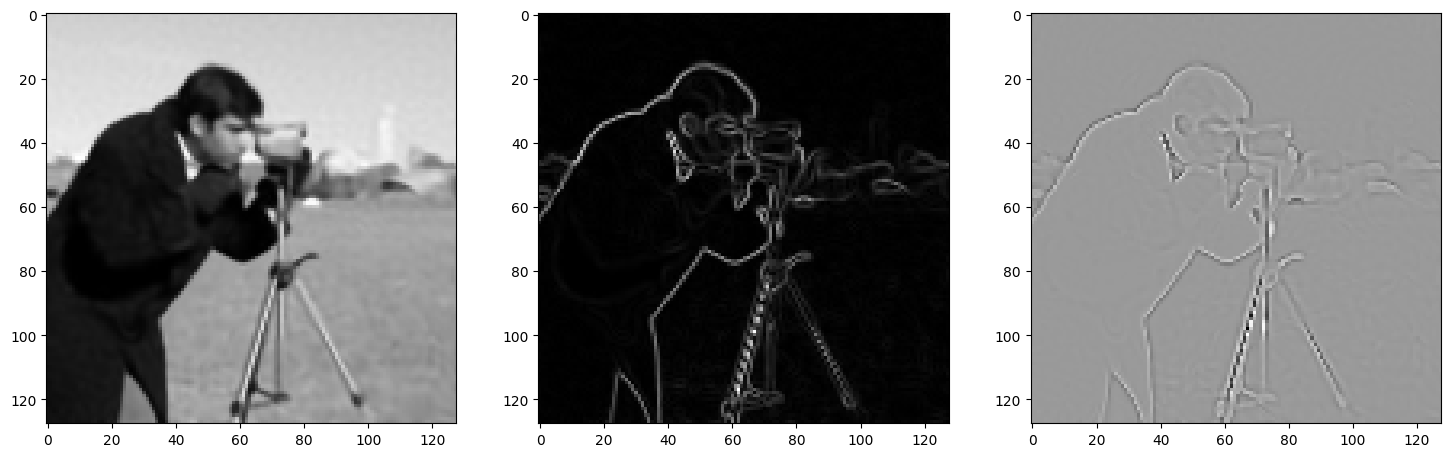

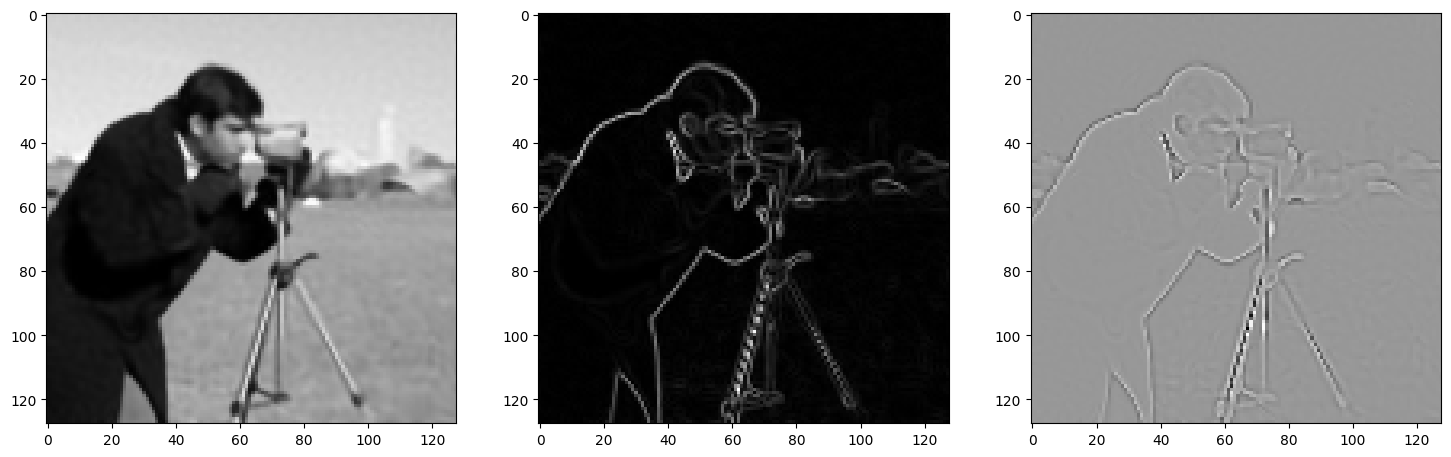

In [7]:
resolution = 128
cameraman = ImageFitting(resolution)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=64,
                  hidden_layers=5, outermost_linear=True)
img_siren.cuda()

epochs = 500
steps_til_summary = 10
learning_rate = 1e-4

optim = torch.optim.Adam(lr=learning_rate, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(epochs):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
        axes[2].imshow(img_laplacian.cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()


model_output, coords = img_siren(model_input)
img_grad = gradient(model_output, coords)
img_laplacian = laplace(model_output, coords)

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(model_output.cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
axes[1].imshow(img_grad.norm(dim=-1).cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
axes[2].imshow(img_laplacian.cpu().view(resolution,resolution).detach().numpy(), cmap='gray')
plt.show()


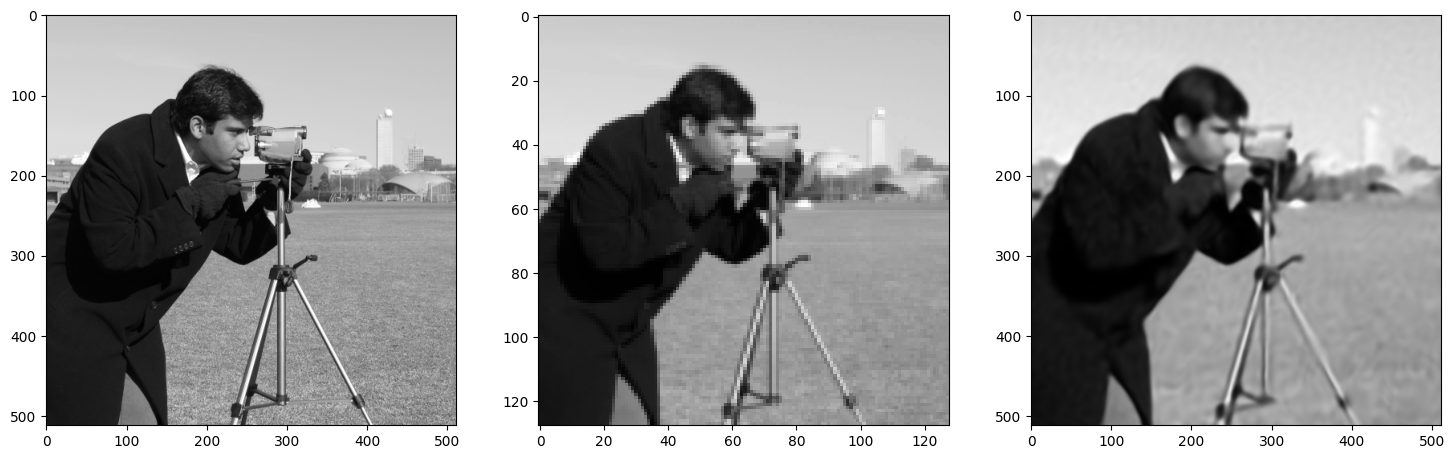

In [23]:
scale = 4
res = int(resolution * scale)

model_output, coords = img_siren(get_mgrid(res).cuda())

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(skimage.data.camera(), cmap='gray')
axes[1].imshow(np.squeeze(get_cameraman_tensor(resolution).detach().numpy()), cmap='gray')
axes[2].imshow(model_output.cpu().view(res, res).detach().numpy(), cmap='gray')


plt.show()

In [15]:
torch.save(img_siren, "img_siren.pth")


In [7]:
import torch
img_siren = torch.load("img_siren.pth")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Siren was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Siren])` or the `torch.serialization.safe_globals([Siren])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [11]:
import wandb

def psnr(im1, im2, max_pixel_value=1):
    return 20 * torch.log10(max_pixel_value / mse(im1, im2))

def mse(im1, im2):
    return F.mse_loss(im1, im2)

wandb.login()

epochs = 500
learning_rate = 1e-4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

for omega in [10, 20, 30, 40]:
    run = wandb.init(
        project="SIREN_omegas",
        name=f"SIREN_omegas_{omega}",
        config={
            "epochs": epochs,
            "learning rate": learning_rate,
            "omega": omega,
        },
    )

    model = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True,  hidden_omega_0=omega, first_omega_0=omega).to(device)

    optim = torch.optim.Adam(lr=learning_rate, params=model.parameters())

    for epoch in range(epochs):
        model_output, coords = model(model_input)

        loss = mse(ground_truth, model_output)

        optim.zero_grad()
        loss.backward()
        optim.step()

        run.log({
            "loss": loss,
            "mse": mse(ground_truth, model_output),
            "psnr": psnr(ground_truth, model_output),
        })

        if not epoch % 10:
            print(f"Epoch {epoch}: loss = {mse(ground_truth, model_output):.4f}, psnr = {psnr(ground_truth, model_output):.4f}")

    run.finish()



Epoch 0: loss = 0.3268, psnr = 9.7155
Epoch 10: loss = 0.0555, psnr = 25.1104
Epoch 20: loss = 0.0427, psnr = 27.3993
Epoch 30: loss = 0.0358, psnr = 28.9305
Epoch 40: loss = 0.0322, psnr = 29.8296
Epoch 50: loss = 0.0302, psnr = 30.4035
Epoch 60: loss = 0.0285, psnr = 30.9109
Epoch 70: loss = 0.0271, psnr = 31.3418
Epoch 80: loss = 0.0259, psnr = 31.7243
Epoch 90: loss = 0.0249, psnr = 32.0660
Epoch 100: loss = 0.0241, psnr = 32.3746
Epoch 110: loss = 0.0233, psnr = 32.6580
Epoch 120: loss = 0.0226, psnr = 32.9249
Epoch 130: loss = 0.0219, psnr = 33.1803
Epoch 140: loss = 0.0213, psnr = 33.4265
Epoch 150: loss = 0.0207, psnr = 33.6635
Epoch 160: loss = 0.0202, psnr = 33.8904
Epoch 170: loss = 0.0197, psnr = 34.1066
Epoch 180: loss = 0.0192, psnr = 34.3121
Epoch 190: loss = 0.0188, psnr = 34.5076
Epoch 200: loss = 0.0184, psnr = 34.6945
Epoch 210: loss = 0.0180, psnr = 34.8745
Epoch 220: loss = 0.0177, psnr = 35.0495
Epoch 230: loss = 0.0173, psnr = 35.2214
Epoch 240: loss = 0.0170, ps

Epoch 0: loss = 0.3246, psnr = 9.7736
Epoch 10: loss = 0.0423, psnr = 27.4659
Epoch 20: loss = 0.0269, psnr = 31.4202
Epoch 30: loss = 0.0218, psnr = 33.2338
Epoch 40: loss = 0.0189, psnr = 34.4593
Epoch 50: loss = 0.0172, psnr = 35.2951
Epoch 60: loss = 0.0158, psnr = 36.0044
Epoch 70: loss = 0.0148, psnr = 36.5893
Epoch 80: loss = 0.0140, psnr = 37.1045
Epoch 90: loss = 0.0132, psnr = 37.5732
Epoch 100: loss = 0.0126, psnr = 38.0086
Epoch 110: loss = 0.0120, psnr = 38.4269
Epoch 120: loss = 0.0114, psnr = 38.8399
Epoch 130: loss = 0.0109, psnr = 39.2541
Epoch 140: loss = 0.0104, psnr = 39.6728
Epoch 150: loss = 0.0099, psnr = 40.0993
Epoch 160: loss = 0.0094, psnr = 40.5369
Epoch 170: loss = 0.0089, psnr = 40.9870
Epoch 180: loss = 0.0085, psnr = 41.4494
Epoch 190: loss = 0.0080, psnr = 41.9209
Epoch 200: loss = 0.0076, psnr = 42.3934
Epoch 210: loss = 0.0072, psnr = 42.8610
Epoch 220: loss = 0.0068, psnr = 43.3224
Epoch 230: loss = 0.0065, psnr = 43.7816
Epoch 240: loss = 0.0061, ps

Epoch 0: loss = 0.3226, psnr = 9.8258
Epoch 10: loss = 0.0445, psnr = 27.0250
Epoch 20: loss = 0.0215, psnr = 33.3659
Epoch 30: loss = 0.0162, psnr = 35.8017
Epoch 40: loss = 0.0135, psnr = 37.3672
Epoch 50: loss = 0.0120, psnr = 38.4302
Epoch 60: loss = 0.0109, psnr = 39.2549
Epoch 70: loss = 0.0100, psnr = 39.9700
Epoch 80: loss = 0.0093, psnr = 40.6273
Epoch 90: loss = 0.0087, psnr = 41.2550
Epoch 100: loss = 0.0081, psnr = 41.8756
Epoch 110: loss = 0.0075, psnr = 42.4985
Epoch 120: loss = 0.0070, psnr = 43.1278
Epoch 130: loss = 0.0065, psnr = 43.7724
Epoch 140: loss = 0.0060, psnr = 44.4449
Epoch 150: loss = 0.0055, psnr = 45.1598
Epoch 160: loss = 0.0050, psnr = 45.9399
Epoch 170: loss = 0.0046, psnr = 46.8027
Epoch 180: loss = 0.0041, psnr = 47.6987
Epoch 190: loss = 0.0037, psnr = 48.5600
Epoch 200: loss = 0.0034, psnr = 49.3554
Epoch 210: loss = 0.0031, psnr = 50.0752
Epoch 220: loss = 0.0029, psnr = 50.7239
Epoch 230: loss = 0.0028, psnr = 50.9246
Epoch 240: loss = 0.0026, ps

Epoch 0: loss = 0.3256, psnr = 9.7452
Epoch 10: loss = 0.0724, psnr = 22.8105
Epoch 20: loss = 0.0232, psnr = 32.7040
Epoch 30: loss = 0.0140, psnr = 37.0583
Epoch 40: loss = 0.0110, psnr = 39.1427
Epoch 50: loss = 0.0094, psnr = 40.5715
Epoch 60: loss = 0.0083, psnr = 41.6300
Epoch 70: loss = 0.0075, psnr = 42.5402
Epoch 80: loss = 0.0068, psnr = 43.3764
Epoch 90: loss = 0.0062, psnr = 44.1766
Epoch 100: loss = 0.0057, psnr = 44.9505
Epoch 110: loss = 0.0052, psnr = 45.7120
Epoch 120: loss = 0.0047, psnr = 46.4774
Epoch 130: loss = 0.0043, psnr = 47.2697
Epoch 140: loss = 0.0039, psnr = 48.1083
Epoch 150: loss = 0.0035, psnr = 49.0118
Epoch 160: loss = 0.0032, psnr = 49.9690
Epoch 170: loss = 0.0035, psnr = 49.2328
Epoch 180: loss = 0.0027, psnr = 51.5333
Epoch 190: loss = 0.0024, psnr = 52.5476
Epoch 200: loss = 0.0021, psnr = 53.4970
Epoch 210: loss = 0.0020, psnr = 54.1580
Epoch 220: loss = 0.0018, psnr = 54.8088
Epoch 230: loss = 0.0017, psnr = 55.3722
Epoch 240: loss = 0.0016, ps

In [1]:
import wandb
import nrrd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_scan_tensor()
        self.pixels = img.flatten()
        self.coords = get_mgrid(sidelength, 3)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

def get_scan_tensor():
    data, headers = nrrd.read("ASOCA_001_0000.nrrd")
    data = torch.from_numpy(data)
    data = data.float()
    data = (data - data.min()) / (data.max() - data.min())
    return data

def psnr(im1, im2, max_pixel_value=1):
    return 20 * torch.log10(max_pixel_value / mse(im1, im2))

def mse(im1, im2):
    return F.mse_loss(im1, im2)

wandb.login()

epochs = 500
learning_rate = 1e-4

scan = ImageFitting(512)
dataloader = DataLoader(scan, batch_size=1, pin_memory=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)


run = wandb.init(
    project="SIREN_scans",
    name=f"SIREN_scan",
    config={
        "epochs": epochs,
        "learning rate": learning_rate,
    },
)

model = Siren(in_features=3, out_features=1, hidden_features=256,
              hidden_layers=3, outermost_linear=True).to(device)

optim = torch.optim.Adam(lr=learning_rate, params=model.parameters())



for epoch in range(epochs):
    model_output, coords = model(model_input)

    loss = mse(ground_truth, model_output)
    psnr = psnr(ground_truth, model_output)

    optim.zero_grad()
    loss.backward()
    optim.step()

    run.log({
        "loss": loss,
        "psnr": psnr,
    })

    if not epoch % 10:
        print(f"Epoch {epoch}: loss = {loss:.4f}, psnr = {psnr:.4f}")

run.finish()



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: steftaz (steftaz-universiteit-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
C:\Users\stevenT\PycharmProjects\SIREN\.venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NameError: name 'Siren' is not defined